<a href="https://colab.research.google.com/github/liadekel/analyzing-big-data/blob/master/Lecture_7_From_Unstructured_Text_to_Structured_Data_Part_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 7: From Unstructured Texts to Structured Data - Part II
### [The Art of Analyzing Big Data - The Data Scientist’s Toolbox](https://www.ise.bgu.ac.il/labs/fire/lectures.html) 
By Dr. Michael Fire



---


## 0. Package Setup
For this lecture, we are going to use the [Kaggle](https://github.com/Kaggle/kaggle-api), [TuriCreate](https://github.com/apple/turicreate), [Gensim](https://radimrehurek.com/gensim/), [pyLDAvis](https://github.com/bmabey/pyLDAvis/blob/master/README.rst), [spaCy](https://spacy.io), [NLTK](https://www.nltk.org), [Plotly Express](https://plotly.com/python/plotly-express/) [Afinn](https://github.com/fnielsen/afinn) packages. Let's set them up:

In [0]:
!pip install turicreate
!pip install kaggle 
!pip install gensim
!pip install pyLDAvis
!pip install spaCy
!pip install afinn
!pip install nltk
!pip install plotly_express

import nltk
nltk.download('stopwords')
nltk.download('punkt')

!python -m spacy download en_core_web_lg # Important! you need to restart runtime after install

     |████████████████████████████████| 91.8MB 33kB/s 
     |████████████████████████████████| 327kB 34.4MB/s 
     |████████████████████████████████| 86.3MB 36kB/s 
     |████████████████████████████████| 3.4MB 27.9MB/s 
     |████████████████████████████████| 450kB 42.3MB/s 
     |████████████████████████████████| 3.8MB 30.7MB/s 
  Created wheel for resampy: filename=resampy-0.2.1-cp36-none-any.whl size=320850 sha256=ba2405b1b89fd3198f54e3fd36c801fbbfc1abf65faad14cc84887deff0d1da6
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=a619d2fccd5b979b698e440123a55ee63afdd11ffc8b1bc6216a36e1cacf197f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built resampy gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
 

In [0]:
#setting up Kaggle & TuriCreate package s
import json
import os

!mkdir /root/.kaggle/
# Installing the Kaggle package

#Important Note: complete this with your own key - after running this for the first time remmember to **remove** your API_KEY
api_token = {"username":"<Insert Your Kaggle User Name>","key":"<Insert Your Kaggle API key>"}

# creating kaggle.json file with the personal API-Key details 
# You can also put this file on your Google Drive

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


## Example 1: The World of Fake News

In this example, we are going to use the methods we learned in order to create a fake news classifier. For this example, we will use the [Fake News Dataset](https://www.kaggle.com/jruvika/fake-news-detection). First let's load the dataset into a DataFrame object:

In [0]:
!mkdir ./datasets
!mkdir ./datasets/fake-news

# download the dataset from Kaggle and unzip it
!kaggle datasets download jruvika/fake-news-detection -p ./datasets/fake-news
!unzip ./datasets/fake-news/*.zip  -d ./datasets/fake-news/

mkdir: cannot create directory ‘./datasets’: File exists
mkdir: cannot create directory ‘./datasets/fake-news’: File exists
100% 4.89M/4.89M [00:00<00:00, 40.1MB/s]

Archive:  ./datasets/fake-news/fake-news-detection.zip
  inflating: ./datasets/fake-news/data.csv  
  inflating: ./datasets/fake-news/data.h5  


In [0]:
import turicreate as tc
%matplotlib inline

fake_news_dataset_path = "./datasets/fake-news/data.csv"
sf = tc.SFrame.read_csv(fake_news_dataset_path)
sf

Finished parsing file /content/datasets/fake-news/data.csv

Parsing completed. Parsed 100 lines in 0.154547 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/datasets/fake-news/data.csv

Parsing completed. Parsed 4009 lines in 0.159761 secs.

Columns:
	URLs	str
	Headline	str
	Body	str
	Label	int

Rows: 4009

Data:
+-------------------------------+-------------------------------+
|              URLs             |            Headline           |
+-------------------------------+-------------------------------+
| http://www.bbc.com/news/wo... | Four ways Bob Corker skewe... |
| https://www.reuters.com/ar... | Linklater's war veteran co... |
| https://www.nytimes.com/20... | Trump’s Fight With Corker ... |
| https://www.reuters.com/ar... | Egypt's Cheiron wins tie-u... |
| http://www.cnn.com/videos/... | Jason Aldean opens 'SNL' w... |
| http://beforeitsnews.com/s... | JetNation FanDuel League; ... |
| https://www.nytimes.com/20... | Kansas Tried a Tax Plan Si... |
| https://www.reuters.com/ar... | India RBI chief: growth im... |
| https://www.reuters.com/ar... | EPA chief to sign rule on ... |
| https://www.reuters.com/ar... | Talks on sale of Air Berli... |
+-------------------------------+-------------------------------+
+-------------------------------+-------+
|              Body             | Label |
+-------------------------------+-------+
| Image copyright Getty Imag... |   1   |
| LONDON (Reuters) - “Last F... |   1   |
| The feud broke into public... |   1   |
| MEXICO CITY (Reuters) - Eg... |   1   |
| Country singer Jason Aldea... |   1   |
| JetNation FanDuel League; ... |   0   |
| In 2012, Kansas lawmakers,... |   1   |
| The Reserve Bank of India ... |   1   |
| Scott Pruitt, Administrato... |   1   |
| FILE PHOTO - An Air Berlin... |   1   |
+-------------------------------+-------+
[4009 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [0]:
sf['full_text'] = sf.apply(lambda r: r['Headline'] + "\n\n" + r['Body'])
sf

Columns:
	URLs	str
	Headline	str
	Body	str
	Label	int
	full_text	str

Rows: 4009

Data:
+-------------------------------+-------------------------------+
|              URLs             |            Headline           |
+-------------------------------+-------------------------------+
| http://www.bbc.com/news/wo... | Four ways Bob Corker skewe... |
| https://www.reuters.com/ar... | Linklater's war veteran co... |
| https://www.nytimes.com/20... | Trump’s Fight With Corker ... |
| https://www.reuters.com/ar... | Egypt's Cheiron wins tie-u... |
| http://www.cnn.com/videos/... | Jason Aldean opens 'SNL' w... |
| http://beforeitsnews.com/s... | JetNation FanDuel League; ... |
| https://www.nytimes.com/20... | Kansas Tried a Tax Plan Si... |
| https://www.reuters.com/ar... | India RBI chief: growth im... |
| https://www.reuters.com/ar... | EPA chief to sign rule on ... |
| https://www.reuters.com/ar... | Talks on sale of Air Berli... |
+-------------------------------+-------------------------------+
+-------------------------------+-------+-------------------------------+
|              Body             | Label |           full_text           |
+-------------------------------+-------+-------------------------------+
| Image copyright Getty Imag... |   1   | Four ways Bob Corker skewe... |
| LONDON (Reuters) - “Last F... |   1   | Linklater's war veteran co... |
| The feud broke into public... |   1   | Trump’s Fight With Corker ... |
| MEXICO CITY (Reuters) - Eg... |   1   | Egypt's Cheiron wins tie-u... |
| Country singer Jason Aldea... |   1   | Jason Aldean opens 'SNL' w... |
| JetNation FanDuel League; ... |   0   | JetNation FanDuel League; ... |
| In 2012, Kansas lawmakers,... |   1   | Kansas Tried a Tax Plan Si... |
| The Reserve Bank of India ... |   1   | India RBI chief: growth im... |
| Scott Pruitt, Administrato... |   1   | EPA chief to sign rule on ... |
| FILE PHOTO - An Air Berlin... |   1   | Talks on sale of Air Berli... |
+-------------------------------+-------+-------------------------------+
[4009 rows x 5 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

Let's use TuriCreate to create topic models for the unreliable news:

In [0]:
import turicreate as tc
from nltk.corpus import stopwords
from nltk.stem.porter import *
from functools import lru_cache
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk


stop_words_set = set(stopwords.words("english"))
stemmer = PorterStemmer()

#Using cahcing for faster performence
@lru_cache(maxsize=None)
def word_stemming(w):
    return stemmer.stem(w)


def skip_word(w):
    if len(w) <2:
        return True
    if w.isdigit():
        return True
    if w in stop_words_set or stemmer.stem(w) in stop_words_set:
        return True
    return False

def text_to_bow(text):
    text = text.lower()
    l = [word_stemming(w) for w in word_tokenize(text) if not skip_word(w) ]
    l = [w for w in l if not skip_word(w)]
    d = Counter(l)
    return dict(d)

f_sf = sf[sf['Label'] == 1]
bow_list = []
for t in f_sf['Headline']:
    bow_list.append(text_to_bow(t))
f_sf['bow'] = bow_list

bow_list = []
for t in f_sf['full_text']:
    bow_list.append(text_to_bow(t))
f_sf['full_bow'] = bow_list

f_sf.materialize()
docs = f_sf['bow']
docs[:2]

dtype: dict
Rows: 2
[{'four': 1, 'way': 1, 'bob': 1, 'corker': 1, 'skewer': 1, 'donald': 1, 'trump': 1}, {'linklat': 1, "'s": 1, 'war': 1, 'veteran': 1, 'comedi': 1, 'speak': 1, 'modern': 1, 'america': 1, 'say': 1, 'star': 1}]

In [0]:
topic_model = tc.topic_model.create(docs, num_topics=100)

Learning a topic model

Number of documents      1872

Vocabulary size      4048

Running collapsed Gibbs sampling

+-----------+---------------+----------------+-----------------+

| Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |

+-----------+---------------+----------------+-----------------+

| 10        | 43.798ms      | 3.98114e+06    | 0               |

+-----------+---------------+----------------+-----------------+

In [0]:
topic_model.get_topics().print_rows(200)

+-------+------------+-----------------------+
| topic |    word    |         score         |
+-------+------------+-----------------------+
|   0   |   trump    |  0.021310320535400298 |
|   0   |    deal    |  0.01602676998943328  |
|   0   |    say     |  0.01602676998943328  |
|   0   |    open    |  0.010743219443466265 |
|   0   |    new     |  0.008982035928143927 |
|   1   |   korea    |  0.009554140127388746 |
|   1   |   gunman   |  0.009554140127388746 |
|   1   |    iran    |  0.007680779318096836 |
|   1   | catalonia  |  0.007680779318096836 |
|   1   |  european  |  0.005807418508804925 |
|   2   |    u.s.    |  0.05055775458798247  |
|   2   |    back    |  0.012774379273120126 |
|   2   |   could    |  0.010975170924793347 |
|   2   |  opposit   |  0.010975170924793347 |
|   2   |   fight    |  0.00737675422813979  |
|   3   |   polit    |  0.012866980790141645 |
|   3   |   anthem   |  0.00924247915911583  |
|   3   | catalonia  |  0.007430228343602922 |
|   3   |   a

Let's use BM25 to find the most relevant items about aliens: 

In [0]:
tc.text_analytics.bm25(f_sf['bow'], ['trump', 'obama']).sort('bm25', ascending=False)

Columns:
	doc_id	int
	bm25	float

Rows: 205

Data:
+--------+-------------------+
| doc_id |        bm25       |
+--------+-------------------+
|  945   | 6.934268829142688 |
|  358   | 6.193069615628017 |
|  121   |  5.98166894704028 |
|  1379  |  5.98166894704028 |
|  1857  | 5.575055437176514 |
|  684   | 5.575055437176514 |
|   29   | 5.575055437176514 |
|  427   | 5.575055437176514 |
|  1268  |  4.90782142209159 |
|  401   | 4.630714726516615 |
+--------+-------------------+
[205 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [0]:
f_sf[945]['Headline']

'Trump administration to roll back Obama clean power rule'

In [0]:
f_sf[358]['Headline']

'Trump Takes a First Step Toward Scrapping Obama’s Global Warming Policy'

In [0]:
tc.text_analytics.bm25(f_sf['bow'], ['brexit']).sort('bm25', ascending=False)

Columns:
	doc_id	int
	bm25	float

Rows: 22

Data:
+--------+-------------------+
| doc_id |        bm25       |
+--------+-------------------+
|  720   | 5.093822731593708 |
|  1323  | 5.093822731593708 |
|  1758  | 4.747561987668387 |
|  1204  | 4.747561987668387 |
|  1390  | 4.747561987668387 |
|  784   | 4.445380163974075 |
|  1640  | 4.445380163974075 |
|  143   | 4.179364077783416 |
|  313   | 4.179364077783416 |
|  1659  | 4.179364077783416 |
+--------+-------------------+
[22 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [0]:
f_sf[1323]['Headline']

'In ‘The Party,’ a Portrait of a U.K. Divided by ‘Brexit’'

Let's find the most common people/organizations/locations in the texts:  

In [0]:
import spacy
from tqdm import tqdm

nlp = spacy.load('en_core_web_lg')
def get_entites_from_text(text):
    entities_dict= {}
    #using spaCy to get entities
    doc = nlp(text)
    for entity in doc.ents:
        label = entity.label_
        if  label not in entities_dict:
            entities_dict[label] = set()
        entities_dict[label].add(entity.text)        

    return entities_dict

l =[] 
for i in tqdm(range(len(sf['full_text']))):
    t = sf[i]['full_text']
    l.append(get_entites_from_text(t))

sf['entities_dict'] = l
f_sf = sf[sf['Label'] == 1]
f_sf

100%|██████████| 4009/4009 [04:41<00:00, 14.26it/s]


Columns:
	URLs	str
	Headline	str
	Body	str
	Label	int
	full_text	str
	entities_dict	dict

Rows: Unknown

Data:
+-------------------------------+-------------------------------+
|              URLs             |            Headline           |
+-------------------------------+-------------------------------+
| http://www.bbc.com/news/wo... | Four ways Bob Corker skewe... |
| https://www.reuters.com/ar... | Linklater's war veteran co... |
| https://www.nytimes.com/20... | Trump’s Fight With Corker ... |
| https://www.reuters.com/ar... | Egypt's Cheiron wins tie-u... |
| http://www.cnn.com/videos/... | Jason Aldean opens 'SNL' w... |
| https://www.nytimes.com/20... | Kansas Tried a Tax Plan Si... |
| https://www.reuters.com/ar... | India RBI chief: growth im... |
| https://www.reuters.com/ar... | EPA chief to sign rule on ... |
| https://www.reuters.com/ar... | Talks on sale of Air Berli... |
| https://www.reuters.com/ar... | Deloitte cyber attack affe... |
+-------------------------------+-------------------------------+
+-------------------------------+-------+-------------------------------+
|              Body             | Label |           full_text           |
+-------------------------------+-------+-------------------------------+
| Image copyright Getty Imag... |   1   | Four ways Bob Corker skewe... |
| LONDON (Reuters) - “Last F... |   1   | Linklater's war veteran co... |
| The feud broke into public... |   1   | Trump’s Fight With Corker ... |
| MEXICO CITY (Reuters) - Eg... |   1   | Egypt's Cheiron wins tie-u... |
| Country singer Jason Aldea... |   1   | Jason Aldean opens 'SNL' w... |
| In 2012, Kansas lawmakers,... |   1   | Kansas Tried a Tax Plan Si... |
| The Reserve Bank of India ... |   1   | India RBI chief: growth im... |
| Scott Pruitt, Administrato... |   1   | EPA chief to sign rule on ... |
| FILE PHOTO - An Air Berlin... |   1   | Talks on sale of Air Berli... |
| FILE PHOTO: The Deloitte C... |   1   | Deloitte cyber attack affe... |
+-------------------------------+-------+-------------------------------+
+-------------------------------+
|         entities_dict         |
+-------------------------------+
| {'CARDINAL': ['four', 'onl... |
| {'PERSON': ['Saddam Hussei... |
| {'ORG': ["The New York Tim... |
| {'GPE': ['MEXICO CITY', 'E... |
| {'PERSON': ['Jason Aldean'... |
| {'GPE': ['Kansas', 'Washin... |
| {'ORG': ['the monetary pol... |
| {'ORG': ['EPA', 'REUTERS/'... |
| {'ORG': ['Air Berlin', 'ea... |
| {'ORG': ['Deloitte', 'The ... |
+-------------------------------+
[? rows x 6 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.

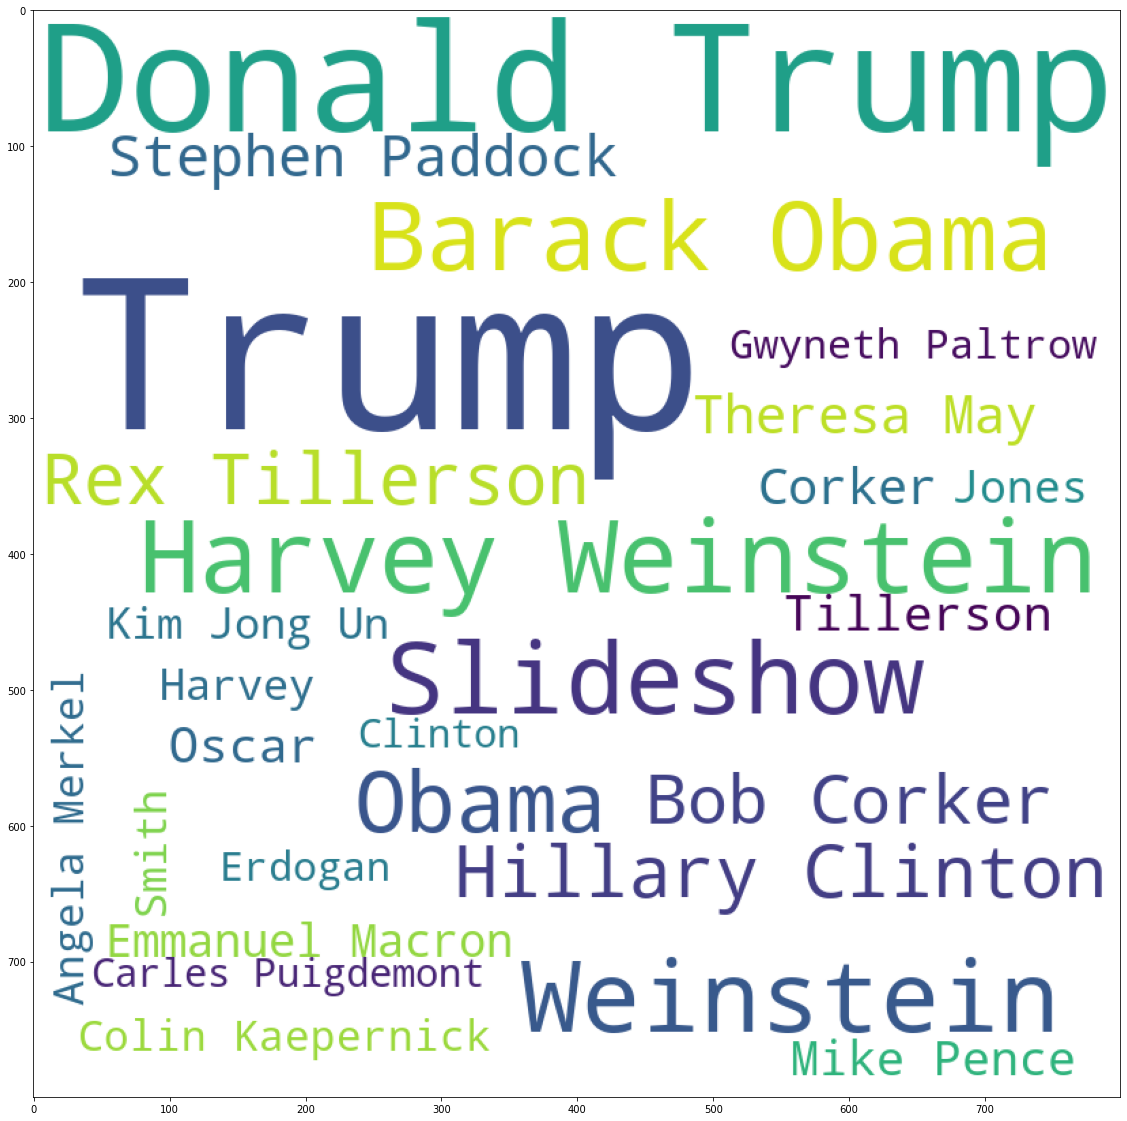

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

def draw_word_cloud(words_list, min_times=10):
    stopwords = set(STOPWORDS) 
    stopwords_parts = {"'s", " ' s'", " `s" }
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10)
    def skip_entity(e):
        if e in stopwords:
            return True
        for p in stopwords_parts:
            if p in e:
                return True
        return False
    c = Counter(words_list)
    # using the subject frquencies
    d = {k:v for k,v in dict(c).items() if v > min_times and not skip_entity(k)}
    wordcloud.generate_from_frequencies(d)
    plt.figure(figsize = (20, 20), facecolor = None) 
    plt.imshow(wordcloud)

find_most_common_person = []
for d in f_sf['entities_dict']:
    if 'PERSON' in d:
        find_most_common_person +=  d['PERSON'] 

draw_word_cloud(find_most_common_person, min_times=20)


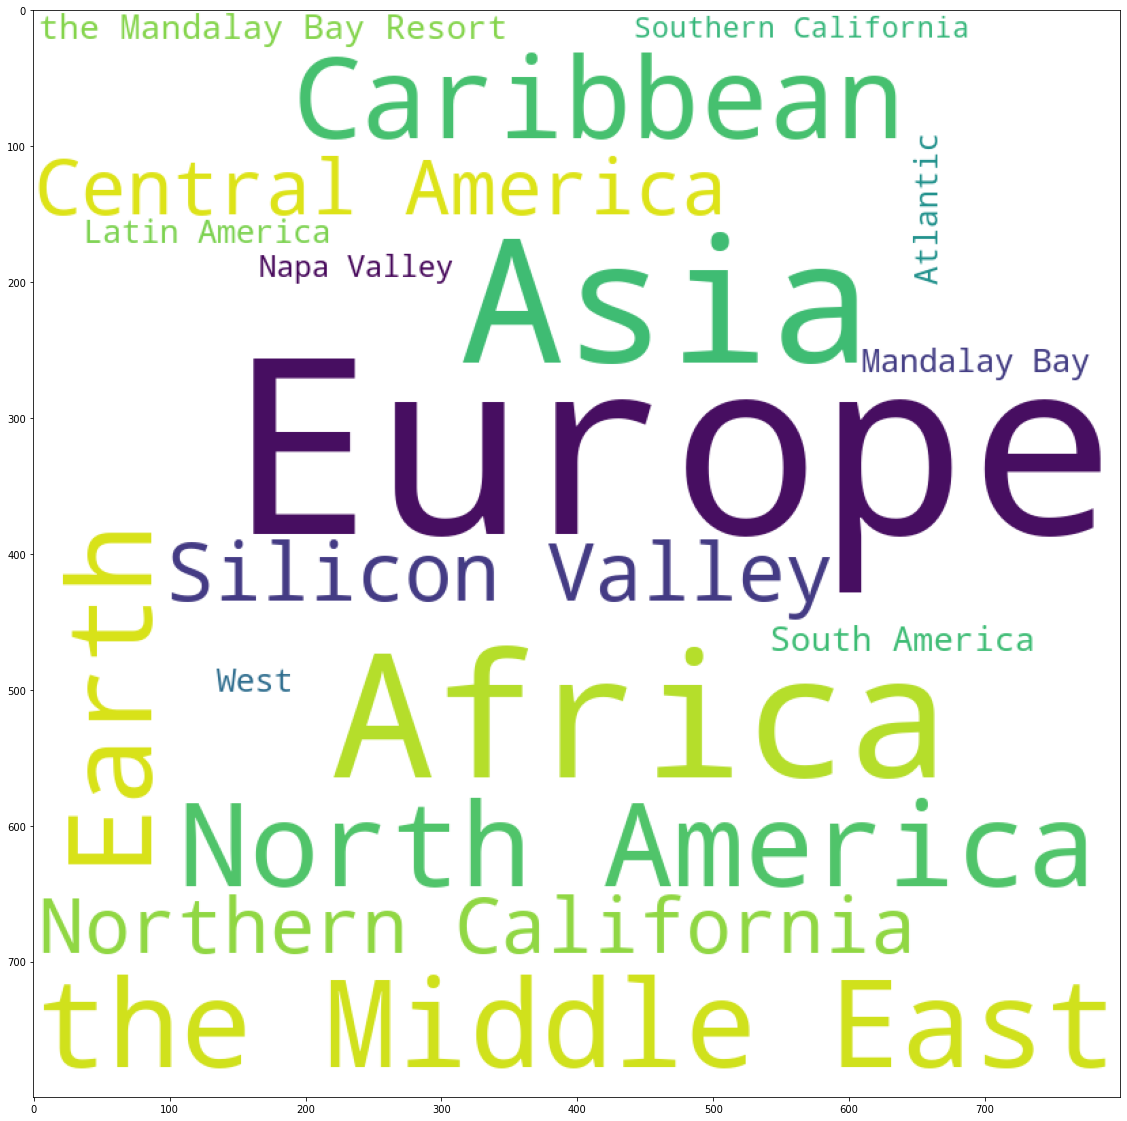

In [0]:
find_most_common_location = []
for d in f_sf['entities_dict']:
    if 'LOC' in d:
        find_most_common_location +=  d['LOC'] 

draw_word_cloud(find_most_common_location, min_times=10)

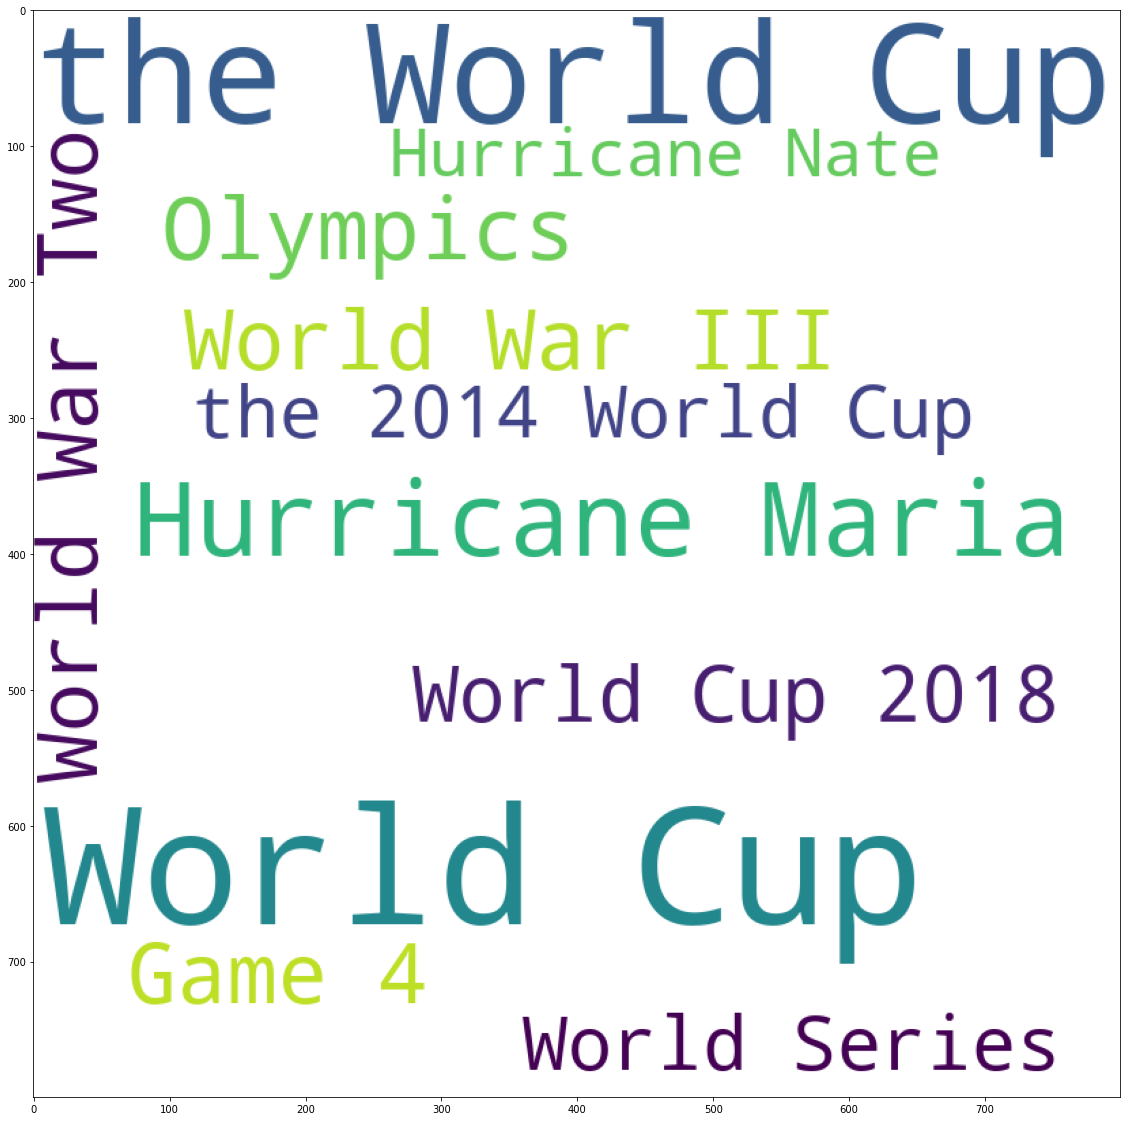

In [0]:
find_most_common_event = []
for d in f_sf['entities_dict']:
    if 'EVENT' in d:
        find_most_common_event +=  d['EVENT'] 

draw_word_cloud(find_most_common_event, min_times=10)

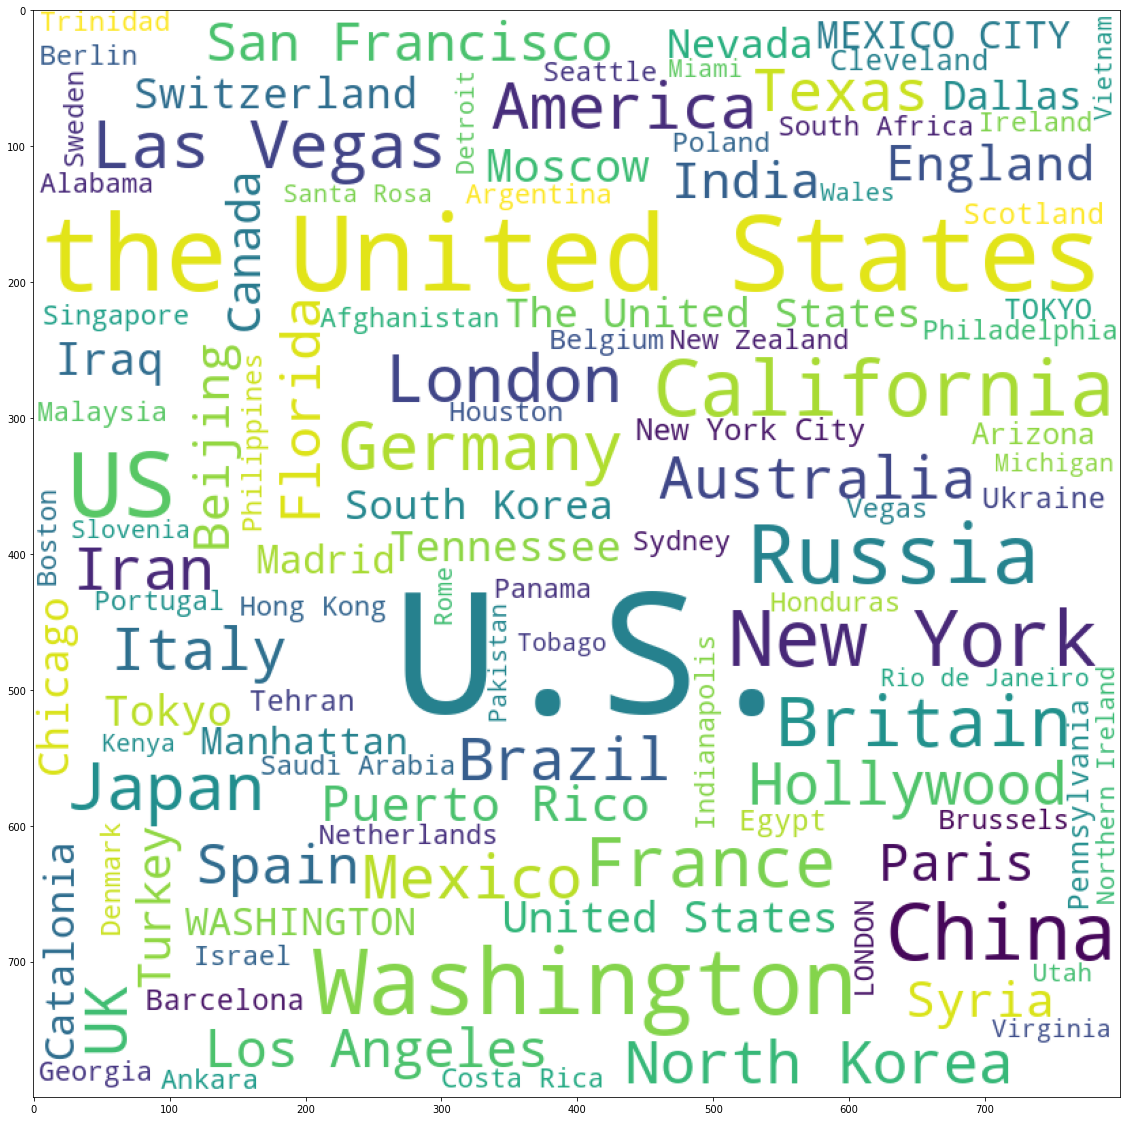

In [0]:
find_most_common_gpe = []
for d in f_sf['entities_dict']:
    if 'GPE' in d:
        find_most_common_gpe +=  d['GPE'] 

draw_word_cloud(find_most_common_gpe, min_times=20)

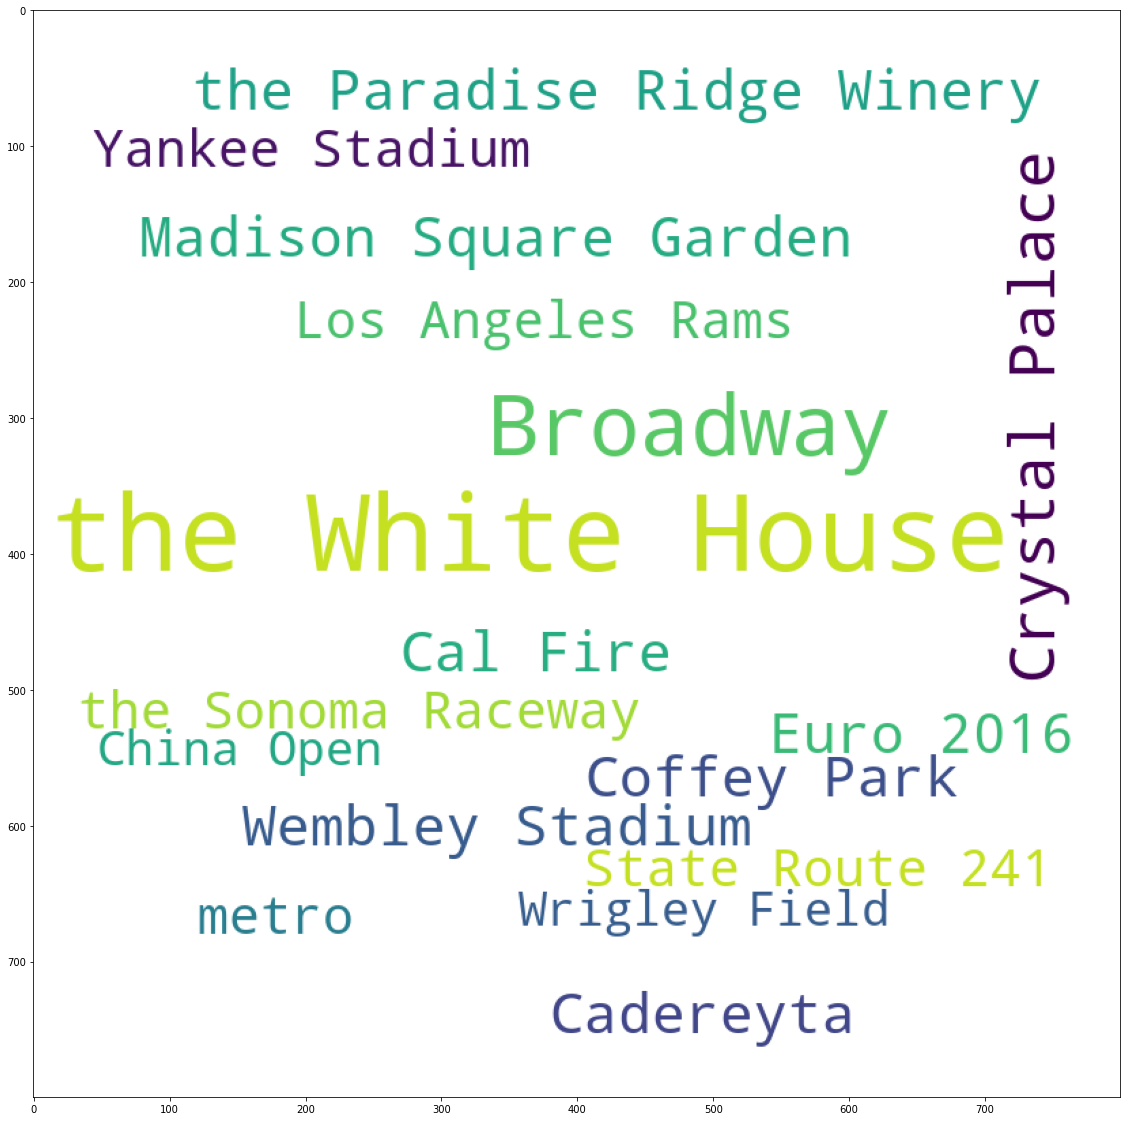

In [0]:
find_most_common_fac = []
for d in f_sf['entities_dict']:
    if 'FAC' in d:
        find_most_common_fac +=  d['FAC'] 

draw_word_cloud(find_most_common_fac, min_times=4)

In [0]:
tc.text_analytics.bm25(f_sf['full_text'], ['world', 'war', 'iii' ]).sort('bm25', ascending=False)

Columns:
	doc_id	int
	bm25	float

Rows: 732

Data:
+--------+--------------------+
| doc_id |        bm25        |
+--------+--------------------+
|  589   | 7.947597796579911  |
|  695   | 7.922955766016632  |
|  995   | 6.671604524990385  |
|  946   | 6.142064357007616  |
|  1308  | 6.1286377226370465 |
|  367   | 6.1090333848883045 |
|  1280  | 5.445422740902873  |
|  386   | 5.3773235264356645 |
|  419   | 5.124491106027198  |
|  109   | 5.102868519584643  |
+--------+--------------------+
[732 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [0]:
f_sf[695]['full_text']

'Steve Bannon\'s war against Mitch McConnell\n\nWashington (CNN) The next step in Steve Bannon\'s scorched-earth war against Republican incumbents is an attempt to cut off money to those aligned with Senate Majority Leader Mitch McConnell.\nThe former chief strategist in President Donald Trump\'s White House spent the weekend in Connecticut meeting with top Republican donors, a source familiar with Bannon\'s plans said, as he recruits financial support for enough candidates to nationalize an anti-establishment message in 2018 GOP primaries.\nHe\'s held similar meetings in New York City and Washington, speaking with more than 25 major GOP donors so far, including hedge fund manager Scott Bessent, energy executive Dan Eberhart, private equity firm CEO John Childs and mega-donors Robert and Rebekah Mercer.\nIt was a continuation of what he\'s done every day since September 26, when the Bannon-backed former judge Roy Moore ousted Sen. Luther Strange in an Alabama Republican primary: Hold m

Let's create a classifier which predicts if a text item is fake or not: 

In [0]:

sf['bow'] = tc.text_analytics.count_words(sf['full_text'])
sf['bow'] = sf['bow'].apply(lambda d: {k:v for k,v in d.items() if v > 1})
sf['tfidf'] = tc.text_analytics.tf_idf(sf['bow'])
train, test = sf.random_split(0.8)
cls = tc.classifier.create(train, features=["bow", "tfidf"], target="Label")

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: LogisticClassifier, SVMClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Logistic regression:

--------------------------------------------------------

Number of examples          : 3072

Number of classes           : 2

Number of feature columns   : 2

Number of unpacked features : 34962

Number of coefficients      : 34963

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.038774     | 0.958984          | 0.876543            |

| 1         | 4        | 1.000000  | 0.077953     | 0.975911          | 0.901235            |

| 2         | 5        | 1.000000  | 0.105493     | 0.976888          | 0.907407            |

| 3         | 6        | 1.000000  | 0.134695     | 0.976237          | 0.919753            |

| 4         | 7        | 1.000000  | 0.162843     | 0.975911          | 0.907407            |

| 9         | 13       | 1.000000  | 0.290081     | 0.982096          | 0.895062            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 3072

Number of classes           : 2

Number of feature columns   : 2

Number of unpacked features : 34962

Number of coefficients    : 34963

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.037431     | 0.958984          | 0.876543            |

| 1         | 4        | 1.000000  | 0.071464     | 0.973633          | 0.895062            |

| 2         | 5        | 1.000000  | 0.094741     | 0.975911          | 0.901235            |

| 3         | 6        | 1.000000  | 0.119231     | 0.975911          | 0.913580            |

| 4         | 7        | 1.000000  | 0.142362     | 0.975260          | 0.913580            |

| 9         | 15       | 0.366662  | 0.280086     | 0.978190          | 0.901235            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: LogisticClassifier              : 0.8950617283950617
PROGRESS: SVMClassifier                   : 0.9012345679012346
PROGRESS: ---------------------------------------------
PROGRESS: Selecting SVMClassifier based on validation set performance.


In [0]:
cls.evaluate(test)

{'accuracy': 0.9058064516129032, 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        1        |   35  |
 |      1       |        0        |   38  |
 |      0       |        0        |  365  |
 |      1       |        1        |  337  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns], 'f1_score': 0.9022757697456493, 'precision': 0.9059139784946236, 'recall': 0.8986666666666666}

In [0]:
l = []
for t in tqdm(sf['full_text']):
    l.append(nlp(t).vector)
sf['vector'] = l 

100%|██████████| 4009/4009 [04:44<00:00, 14.07it/s]


In [0]:
train, test = sf.random_split(0.8)
cls1 = tc.classifier.create(train, features=["bow", "tfidf"], target="Label")
cls1.evaluate(test)                                            

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: LogisticClassifier, SVMClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Logistic regression:

--------------------------------------------------------

Number of examples          : 3078

Number of classes           : 2

Number of feature columns   : 2

Number of unpacked features : 35728

Number of coefficients      : 35729

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.037674     | 0.958090          | 0.895706            |

| 1         | 4        | 1.000000  | 0.088670     | 0.975634          | 0.932515            |

| 2         | 5        | 1.000000  | 0.122346     | 0.974659          | 0.920245            |

| 3         | 6        | 1.000000  | 0.156051     | 0.974009          | 0.938650            |

| 4         | 7        | 1.000000  | 0.189333     | 0.974334          | 0.932515            |

| 9         | 16       | 0.639990  | 0.374330     | 0.981806          | 0.926380            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 3078

Number of classes           : 2

Number of feature columns   : 2

Number of unpacked features : 35728

Number of coefficients    : 35729

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.035264     | 0.958090          | 0.895706            |

| 1         | 4        | 1.000000  | 0.073048     | 0.974659          | 0.907975            |

| 2         | 5        | 1.000000  | 0.101759     | 0.974334          | 0.920245            |

| 3         | 6        | 1.000000  | 0.129869     | 0.974009          | 0.926380            |

| 4         | 7        | 1.000000  | 0.156812     | 0.973034          | 0.932515            |

| 9         | 15       | 0.726389  | 0.317364     | 0.976608          | 0.938650            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: LogisticClassifier              : 0.9263803680981595
PROGRESS: SVMClassifier                   : 0.9386503067484663
PROGRESS: ---------------------------------------------
PROGRESS: Selecting SVMClassifier based on validation set performance.


{'accuracy': 0.9127604166666666, 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |   28  |
 |      0       |        1        |   39  |
 |      0       |        0        |  361  |
 |      1       |        1        |  340  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns], 'f1_score': 0.9103078982597055, 'precision': 0.8970976253298153, 'recall': 0.9239130434782609}

In [0]:
cls2 = tc.classifier.create(train, features=["vector"], target="Label")
cls2.evaluate(test)                                            

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: LogisticClassifier, SVMClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Logistic regression:

--------------------------------------------------------

Number of examples          : 3078

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 300

Number of coefficients      : 301

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.532891     | 0.973684          | 0.889571            |

| 2         | 3        | 0.827799     | 0.981806          | 0.889571            |

| 3         | 4        | 1.111207     | 0.989929          | 0.932515            |

| 4         | 5        | 1.401041     | 0.995127          | 0.932515            |

| 5         | 6        | 1.686715     | 0.996751          | 0.944785            |

| 10        | 11       | 3.119999     | 1.000000          | 0.944785            |

+-----------+----------+--------------+-------------------+---------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

SVM:

--------------------------------------------------------

Number of examples          : 3078

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 300

Number of coefficients    : 301

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 4        | 0.250000  | 0.102178     | 0.622482          | 0.588957            |

| 1         | 7        | 1.250000  | 0.195839     | 0.813515          | 0.766871            |

| 2         | 8        | 1.250000  | 0.244609     | 0.828460          | 0.815951            |

| 3         | 9        | 1.250000  | 0.290399     | 0.843730          | 0.815951            |

| 4         | 10       | 1.250000  | 0.337024     | 0.877193          | 0.846626            |

| 9         | 15       | 1.250000  | 0.561235     | 0.950292          | 0.920245            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: LogisticClassifier              : 0.9447852760736196
PROGRESS: SVMClassifier                   : 0.9202453987730062
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.


{'accuracy': 0.9596354166666666,
 'auc': 0.9826256793478252,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        0        |  394  |
 |      1       |        0        |   25  |
 |      1       |        1        |  343  |
 |      0       |        1        |   6   |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.9567642956764296,
 'log_loss': 0.32683281740003367,
 'precision': 0.9828080229226361,
 'recall': 0.9320652173913043,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+--------+--------------------+-----+-----+
 | threshold |  fpr   |        tpr         |  p  |  n  |
 +-----------+--------+--------------------+-----+-----+
 |    0.0    |  1.0   |        1.0         | 368 | 4

## Example 2: The Classical Spam or Ham

In this example, we will analyze SMS texts and try to predict if they are spam or not. Throughout this example we will use the [SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset). Let's 
load this data into an SFrame object:


In [0]:
!mkdir ./datasets
!mkdir ./datasets/sms-spam

# download the dataset from Kaggle and unzip it
!kaggle datasets download uciml/sms-spam-collection-dataset -p ./datasets/sms-spam
!unzip ./datasets/sms-spam/*.zip  -d ./datasets/sms-spam/

  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 65.2MB/s]
Archive:  ./datasets/sms-spam/sms-spam-collection-dataset.zip
  inflating: ./datasets/sms-spam/spam.csv  


In [0]:
import pandas as pd
path = "./datasets/sms-spam/spam.csv" # need to be save with UTF8 encodings

df = pd.read_csv(path, delimiter='',encoding='latin-1')
df

v1  ... Unnamed: 4
0      ham  ...        NaN
1      ham  ...        NaN
2     spam  ...        NaN
3      ham  ...        NaN
4      ham  ...        NaN
...    ...  ...        ...
5567  spam  ...        NaN
5568   ham  ...        NaN
5569   ham  ...        NaN
5570   ham  ...        NaN
5571   ham  ...        NaN

[5572 rows x 5 columns]

In [0]:
import turicreate as tc
sf = tc.SFrame(df[['v1', 'v2']])
sf = sf.rename({'v1':'class', 'v2':'text'})
sf

Columns:
	class	str
	text	str

Rows: 5572

Data:
+-------+-------------------------------+
| class |              text             |
+-------+-------------------------------+
|  ham  | Go until jurong point, cra... |
|  ham  | Ok lar... Joking wif u oni... |
|  spam | Free entry in 2 a wkly com... |
|  ham  | U dun say so early hor... ... |
|  ham  | Nah I don't think he goes ... |
|  spam | FreeMsg Hey there darling ... |
|  ham  | Even my brother is not lik... |
|  ham  | As per your request 'Melle... |
|  spam | WINNER!! As a valued netwo... |
|  spam | Had your mobile 11 months ... |
+-------+-------------------------------+
[5572 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

Let's explore the data a little before constructing a classifier:

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


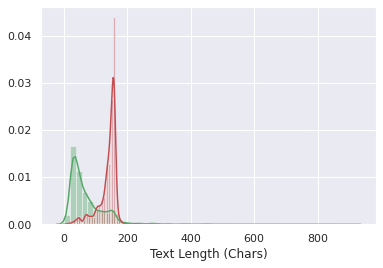

In [0]:
import seaborn as sns
%matplotlib inline
sns.set()

sf['length'] = sf['text'].apply(lambda t: len(t))
sns.distplot(sf[sf['class'] == 'ham']['length'], axlabel="Text Length (Chars)", color='g')
sns.distplot(sf[sf['class'] == 'spam']['length'], axlabel="Text Length (Chars)", color='r')

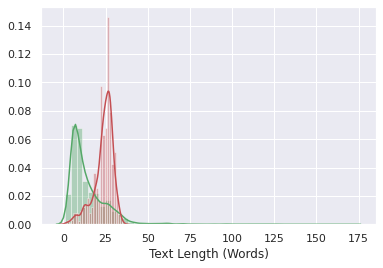

In [0]:
sf['words_num'] = sf['text'].apply(lambda t: len(t.split()))
sns.distplot(sf[sf['class'] == 'ham']['words_num'], axlabel="Text Length (Words)", color='g')
sns.distplot(sf[sf['class'] == 'spam']['words_num'], axlabel="Text Length (Words)", color='r')

Let's find the most common 2-grams in the text:

In [0]:
from collections import Counter
from nltk.tokenize import word_tokenize

def get_most_common_bigrams(txt):
    words = word_tokenize(txt)
    bigrams = [f"{w1} {w2}" for w1,w2 in zip(words, words[1:])]

    c = Counter(bigrams)
    return c
txt = "\n".join(sf['text'])
c = get_most_common_bigrams(txt)
c.most_common(20)

[('. I', 504),
 ('& lt', 314),
 ('lt ;', 314),
 ('& gt', 314),
 ('gt ;', 314),
 ("I 'm", 286),
 ('# &', 280),
 ('; #', 276),
 (': )', 251),
 ('? I', 174),
 (', I', 166),
 ("I 'll", 137),
 ('... I', 135),
 ('. You', 126),
 (': -', 125),
 ('! !', 120),
 ('- )', 114),
 ("do n't", 112),
 ('. .', 108),
 ('! I', 107)]

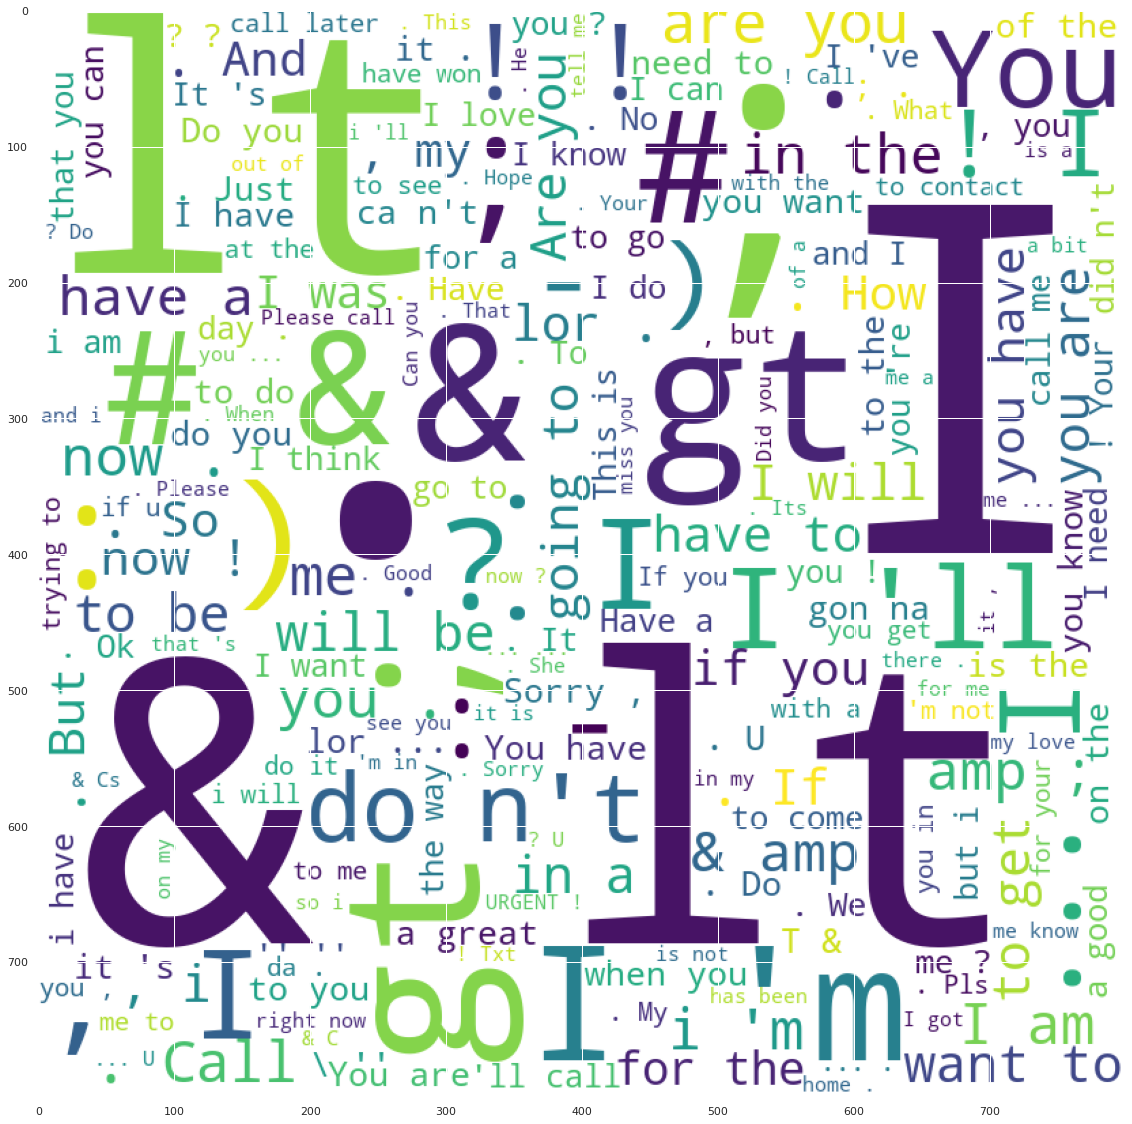

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

def draw_sms_words_cloud(d):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    min_font_size = 10)

    wordcloud.generate_from_frequencies(d)
    plt.figure(figsize = (20, 20), facecolor = None) 
    plt.imshow(wordcloud)
                                        
draw_sms_words_cloud(dict(c))


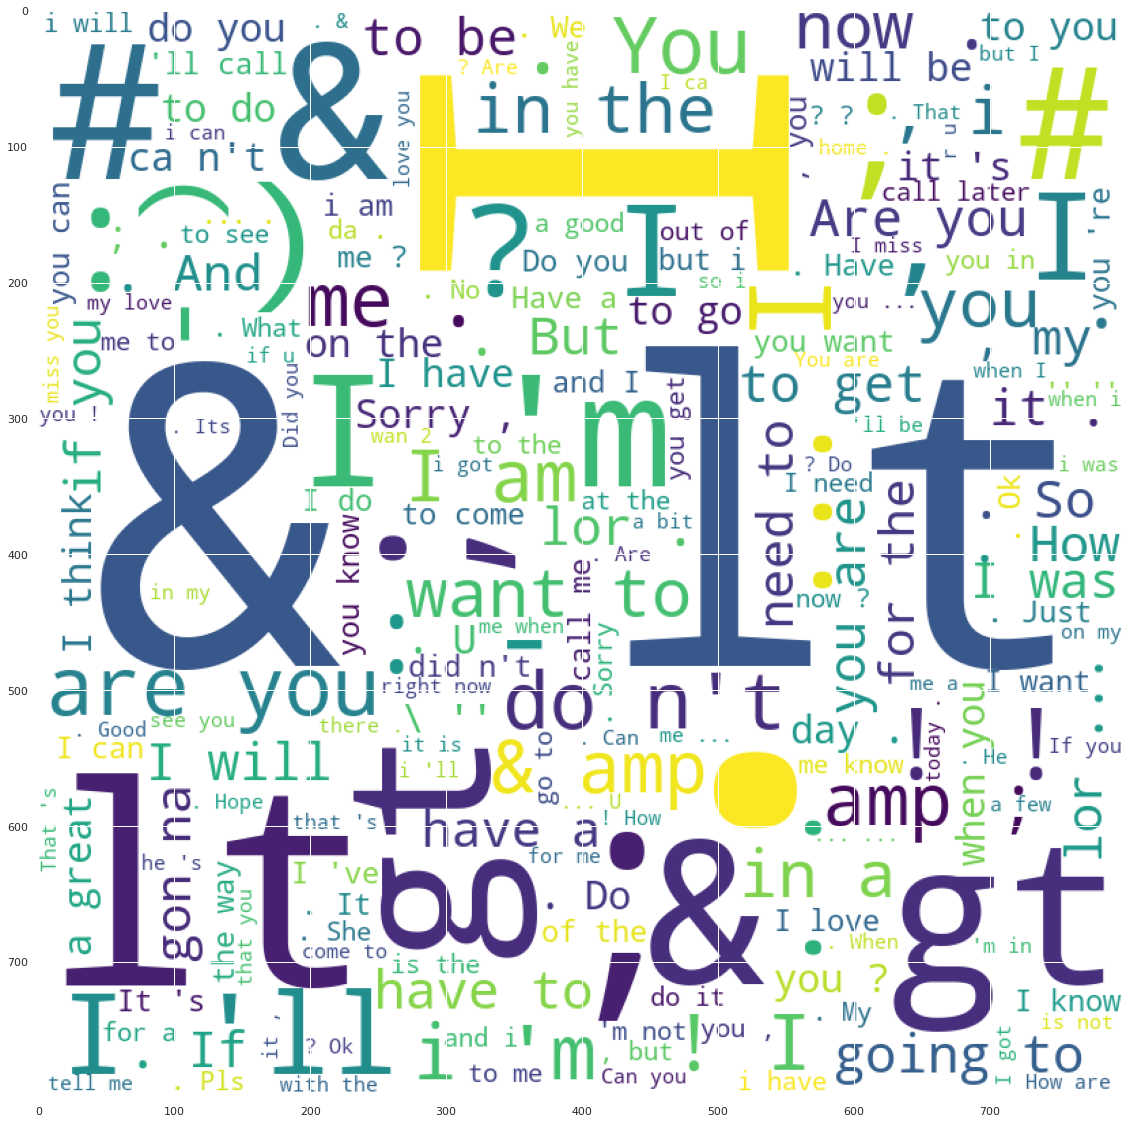

In [0]:
txt = "\n".join(sf[sf['class'] == 'ham']['text'])
c = get_most_common_bigrams(txt)
c.most_common(20)
draw_sms_words_cloud(dict(c))

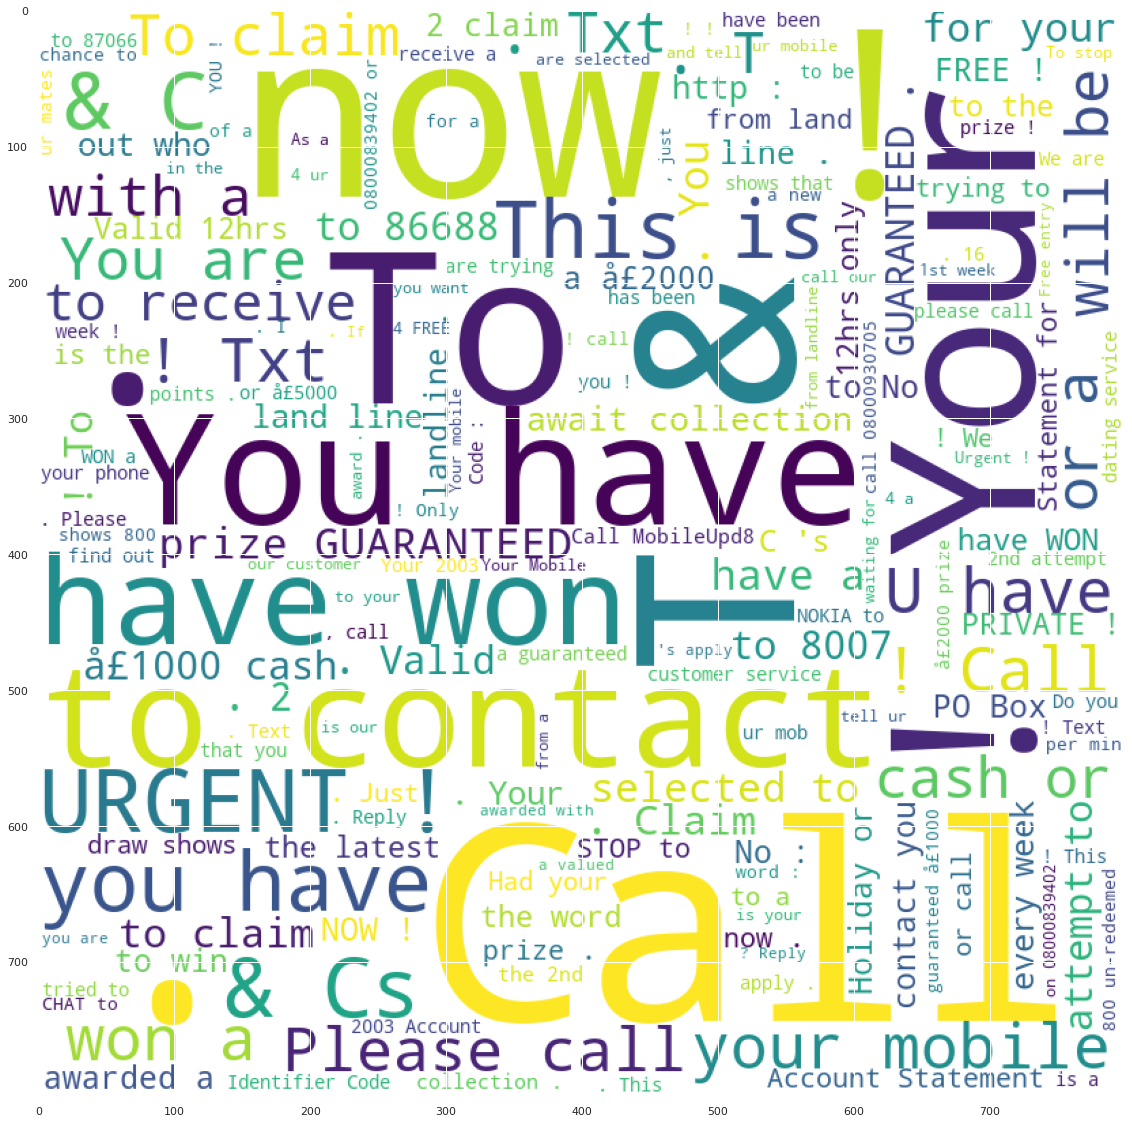

In [0]:
txt = "\n".join(sf[sf['class'] == 'spam']['text'])
c = get_most_common_bigrams(txt)
c.most_common(20)
draw_sms_words_cloud(dict(c))

In this dataset, the differences between SPAM/HAM messages are obvious right away from the above figures -- Spam message are on average longer and tend to call for action.
Let's create a classifier which can predict if a text is spam or ham:

In [0]:
sf['1grams-words'] = tc.text_analytics.count_ngrams(sf['text'], n=1, method="word")
sf['2grams-words'] = tc.text_analytics.count_ngrams(sf['text'], n=2, method="word")

sf['1grams-chars'] = tc.text_analytics.count_ngrams(sf['text'], n=1, method="character")
sf['2grams-chars'] = tc.text_analytics.count_ngrams(sf['text'], n=2, method="character")



train,test = sf.random_split(0.8)
cls1 = tc.classifier.create(train, features=["2grams-words"], target="class")
cls2 = tc.classifier.create(train, features=["2grams-chars"], target="class")
cls3 = tc.classifier.create(train, features=["2grams-chars", "1grams-chars", "2grams-words", "1grams-words"], target="class")

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: LogisticClassifier, SVMClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Logistic regression:

--------------------------------------------------------

Number of examples          : 4280

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 35300

Number of coefficients      : 35301

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 1.037663     | 0.999533          | 0.977876            |

| 1         | 4        | 1.000000  | 1.054872     | 1.000000          | 0.977876            |

| 2         | 5        | 1.000000  | 1.065864     | 1.000000          | 0.977876            |

| 3         | 7        | 1.000000  | 1.085452     | 1.000000          | 0.973451            |

| 4         | 9        | 1.000000  | 1.103558     | 1.000000          | 0.969027            |

| 9         | 19       | 1.000000  | 1.183731     | 1.000000          | 0.951327            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 4280

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 35300

Number of coefficients    : 35301

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.038056     | 0.999533          | 0.977876            |

| 1         | 4        | 1.000000  | 0.053273     | 1.000000          | 0.977876            |

| 2         | 5        | 1.000000  | 0.064081     | 1.000000          | 0.977876            |

| 3         | 6        | 1.000000  | 0.077205     | 1.000000          | 0.977876            |

| 4         | 7        | 1.000000  | 0.090118     | 1.000000          | 0.977876            |

| 9         | 15       | 5.000000  | 0.155420     | 0.865888          | 0.880531            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: LogisticClassifier              : 0.9513274336283186
PROGRESS: SVMClassifier                   : 0.8805309734513275
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: LogisticClassifier, SVMClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Logistic regression:

--------------------------------------------------------

Number of examples          : 4280

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 1358

Number of coefficients      : 1359

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 3        | 0.500000  | 0.056219     | 0.882477          | 0.876106            |

| 1         | 5        | 0.500000  | 0.086042     | 0.921963          | 0.920354            |

| 2         | 7        | 0.500000  | 0.117016     | 0.948832          | 0.942478            |

| 3         | 9        | 0.500000  | 0.147248     | 0.966822          | 0.960177            |

| 4         | 11       | 0.500000  | 0.176280     | 0.973364          | 0.969027            |

| 9         | 18       | 0.976563  | 0.292301     | 0.997196          | 0.986726            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 4280

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 1358

Number of coefficients    : 1359

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 3        | 0.500000  | 0.055266     | 0.882477          | 0.876106            |

| 1         | 5        | 0.500000  | 0.084492     | 0.916121          | 0.920354            |

| 2         | 7        | 0.500000  | 0.115215     | 0.953738          | 0.946903            |

| 3         | 8        | 0.625000  | 0.134935     | 0.970093          | 0.964602            |

| 4         | 9        | 0.781250  | 0.154657     | 0.981776          | 0.977876            |

| 9         | 15       | 1.000000  | 0.243378     | 0.996729          | 0.991150            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: LogisticClassifier              : 0.9867256637168141
PROGRESS: SVMClassifier                   : 0.9911504424778761
PROGRESS: ---------------------------------------------
PROGRESS: Selecting SVMClassifier based on validation set performance.
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: LogisticClassifier, SVMClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Logistic regression:

--------------------------------------------------------

Number of examples          : 4280

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 44695

Number of coefficients      : 44696

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.096825     | 0.948364          | 0.929204            |

| 1         | 4        | 1.000000  | 0.168920     | 0.998131          | 0.964602            |

| 2         | 5        | 1.000000  | 0.223556     | 0.999766          | 0.964602            |

| 3         | 6        | 1.000000  | 0.270456     | 1.000000          | 0.964602            |

| 4         | 7        | 1.000000  | 0.316266     | 1.000000          | 0.964602            |

| 9         | 15       | 1.000000  | 0.612283     | 1.000000          | 0.964602            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 4280

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 44695

Number of coefficients    : 44696

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.073959     | 0.948364          | 0.929204            |

| 1         | 4        | 1.000000  | 0.143669     | 0.992991          | 0.964602            |

| 2         | 5        | 1.000000  | 0.192318     | 0.998598          | 0.964602            |

| 3         | 6        | 1.000000  | 0.237731     | 0.999766          | 0.964602            |

| 4         | 7        | 1.000000  | 0.284893     | 1.000000          | 0.964602            |

Warning: Reached max step size.

| 9         | 36       | 0.038450  | 1.028773     | 1.000000          | 0.964602            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: LogisticClassifier              : 0.9646017699115044
PROGRESS: SVMClassifier                   : 0.9646017699115044
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.


In [0]:
cls1.evaluate(test)

{'accuracy': 0.9549718574108818,
 'auc': 0.9603230037329334,
 'confusion_matrix': Columns:
 	target_label	str
 	predicted_label	str
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |     ham      |       spam      |   1   |
 |     spam     |       spam      |   92  |
 |     spam     |       ham       |   47  |
 |     ham      |       ham       |  926  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.7931034482758622,
 'log_loss': 0.16068778157240085,
 'precision': 0.989247311827957,
 'recall': 0.6618705035971223,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+--------------------+--------------------+-----+-----+
 | threshold |        fpr         |        tpr         |  p  |  n  |
 +-----------+--------------------+--------------------+-----+-----+
 |    0.0    |   

In [0]:
cls2.evaluate(test)

{'accuracy': 0.9774859287054409, 'confusion_matrix': Columns:
 	target_label	str
 	predicted_label	str
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |     ham      |       spam      |   10  |
 |     spam     |       ham       |   14  |
 |     spam     |       spam      |  125  |
 |     ham      |       ham       |  917  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns], 'f1_score': 0.9124087591240877, 'precision': 0.9259259259259259, 'recall': 0.8992805755395683}

In [0]:
cls3.evaluate(test)

{'accuracy': 0.9699812382739212,
 'auc': 0.9460703282034575,
 'confusion_matrix': Columns:
 	target_label	str
 	predicted_label	str
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |     ham      |       spam      |   2   |
 |     spam     |       ham       |   30  |
 |     spam     |       spam      |  109  |
 |     ham      |       ham       |  925  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.872,
 'log_loss': 0.3182738702129309,
 'precision': 0.9819819819819819,
 'recall': 0.7841726618705036,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+---------------------+--------------------+-----+-----+
 | threshold |         fpr         |        tpr         |  p  |  n  |
 +-----------+---------------------+--------------------+-----+-----+
 |    0.0    |         1.0 

Let's look on the spam SMS messages, which  were classified as ham:

In [0]:
cls3.classify(test)

Columns:
	class	str
	probability	float

Rows: 1066

Data:
+-------+--------------------+
| class |    probability     |
+-------+--------------------+
|  ham  | 0.9999990002398513 |
|  ham  |        1.0         |
|  ham  | 0.9995834480561274 |
|  spam | 0.9999425714202878 |
|  ham  | 0.9999972350321963 |
|  ham  | 0.9999999999999998 |
|  ham  |        1.0         |
|  ham  |        1.0         |
|  ham  | 0.9999999331447454 |
|  ham  | 0.999898983481589  |
+-------+--------------------+
[1066 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [0]:
test['predicted_prob'] = cls3.classify(test)['probability']
test['predicted_class'] = cls3.classify(test)['class']
spam_test =test[test['class'] == 'spam']

In [0]:
l = list(spam_test[spam_test['predicted_class'] == 'ham']['text'])
print(len(l))
for m in l:
    print(f"{m}\n\n")


30
Customer service annoncement. You have a New Years delivery waiting for you. Please call 07046744435 now to arrange delivery


Are you unique enough? Find out from 30th August. www.areyouunique.co.uk


SMS. ac Blind Date 4U!: Rodds1 is 21/m from Aberdeen, United Kingdom. Check Him out http://img. sms. ac/W/icmb3cktz8r7!-4 no Blind Dates send HIDE


Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?


Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r


Filthy stories and GIRLS waiting for your


1000's flirting NOW! Txt GIRL or BLOKE & ur NAME & AGE, eg GIRL ZOE 18 to 8007 to join and get chatting!


SMS. ac JSco: Energy is high, but u may not know where 2channel it. 2day ur leadership skills r strong. Psychic? Reply ANS w/question. End? Reply END JSCO


Monthly password for wap. mobsi.com is 391784. Use your wap phone not PC.


Free msg. Sorry, a s

## Example 3: Movie Genre Classification

In this example, we will develop a simple classifier which can predict the category of a movie from 
the movie's Wikipedia plot summary descriptions. To achieve this, we will use the [Wikipedia Movie Plots dataset](https://www.kaggle.com/jrobischon/wikipedia-movie-plots). Let's load the dataset into an SFrame object:


In [0]:
!mkdir ./datasets
!mkdir ./datasets/movie-plots

# download the dataset from Kaggle and unzip it
!kaggle datasets download jrobischon/wikipedia-movie-plots -p ./datasets/movie-plots
!unzip ./datasets/movie-plots/*.zip  -d ./datasets/movie-plots/

 84% 25.0M/29.9M [00:00<00:00, 40.9MB/s]
100% 29.9M/29.9M [00:00<00:00, 99.9MB/s]
Archive:  ./datasets/movie-plots/wikipedia-movie-plots.zip
  inflating: ./datasets/movie-plots/wiki_movie_plots_deduped.csv  


In [0]:
import pandas as pd
import turicreate as tc
import turicreate.aggregate as agg

path = "./datasets/movie-plots/wiki_movie_plots_deduped.csv"

df = pd.read_csv(path)
sf = tc.SFrame(df[['Title', 'Genre', 'Plot']])
sf

Columns:
	Title	str
	Genre	str
	Plot	str

Rows: 34886

Data:
+-------------------------------+---------+-------------------------------+
|             Title             |  Genre  |              Plot             |
+-------------------------------+---------+-------------------------------+
|     Kansas Saloon Smashers    | unknown | A bartender is working at ... |
| Love by the Light of the Moon | unknown | The moon, painted with a s... |
|    The Martyred Presidents    | unknown | The film, just over a minu... |
| Terrible Teddy, the Grizzl... | unknown | Lasting just 61 seconds an... |
|     Jack and the Beanstalk    | unknown | The earliest known adaptat... |
|      Alice in Wonderland      | unknown | Alice follows a large whit... |
|    The Great Train Robbery    | western | The film opens with two ba... |
|        The Suburbanite        |  comedy | The film is about a family... |
|    The Little Train Robbery   | unknown | The opening scene shows th... |
|   The Night Before Christmas  | unknown | Scenes are introduced usin... |
+-------------------------------+---------+-------------------------------+
[34886 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [0]:
g = sf.groupby('Genre', {'count':agg.COUNT()})
g.sort("count", ascending=False).print_rows(100)

+------------------------+-------+
|         Genre          | count |
+------------------------+-------+
|        unknown         |  6083 |
|         drama          |  5964 |
|         comedy         |  4379 |
|         horror         |  1167 |
|         action         |  1098 |
|        thriller        |  966  |
|        romance         |  923  |
|        western         |  865  |
|         crime          |  568  |
|       adventure        |  526  |
|        musical         |  467  |
|      crime drama       |  464  |
|    romantic comedy     |  461  |
|    science fiction     |  418  |
|       film noir        |  345  |
|        mystery         |  310  |
|          war           |  273  |
|       animation        |  264  |
|     comedy, drama      |  236  |
|         sci-fi         |  221  |
|         family         |  217  |
|        fantasy         |  204  |
|        animated        |  195  |
|     musical comedy     |  154  |
|      comedy-drama      |  137  |
|       biography   

We can see that some of the movies have multiple genres. Let's normalize the data so each row will contain only one genre:


In [0]:
def get_genres(genre):
    genre = str(genre).lower().strip()
    if genre == 'unknown'  or genre == '':
        return None
    if "," not in genre and "/" not in genre:
        return [genre]
    l = []
    genre = genre.replace(",", "/")
    if "/" in genre:
        l = genre.split("/")
    return [g.strip() for g in l]
    
sf['GenreNorm'] = sf['Genre'].apply(lambda g: get_genres(g))
sf

Columns:
	Title	str
	Genre	str
	Plot	str
	GenreNorm	list

Rows: 34886

Data:
+-------------------------------+---------+-------------------------------+
|             Title             |  Genre  |              Plot             |
+-------------------------------+---------+-------------------------------+
|     Kansas Saloon Smashers    | unknown | A bartender is working at ... |
| Love by the Light of the Moon | unknown | The moon, painted with a s... |
|    The Martyred Presidents    | unknown | The film, just over a minu... |
| Terrible Teddy, the Grizzl... | unknown | Lasting just 61 seconds an... |
|     Jack and the Beanstalk    | unknown | The earliest known adaptat... |
|      Alice in Wonderland      | unknown | Alice follows a large whit... |
|    The Great Train Robbery    | western | The film opens with two ba... |
|        The Suburbanite        |  comedy | The film is about a family... |
|    The Little Train Robbery   | unknown | The opening scene shows th... |
|   The Night Before Christmas  | unknown | Scenes are introduced usin... |
+-------------------------------+---------+-------------------------------+
+-----------+
| GenreNorm |
+-----------+
|    None   |
|    None   |
|    None   |
|    None   |
|    None   |
|    None   |
| [western] |
|  [comedy] |
|    None   |
|    None   |
+-----------+
[34886 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [0]:
sf = sf[sf['GenreNorm'] != None]
sf = sf.stack('GenreNorm', new_column_name='GenreNorm')
sf

Columns:
	Title	str
	Genre	str
	Plot	str
	GenreNorm	str

Rows: 34211

Data:
+-------------------------------+----------------------------+
|             Title             |           Genre            |
+-------------------------------+----------------------------+
|    The Great Train Robbery    |          western           |
|        The Suburbanite        |           comedy           |
|    Dream of a Rarebit Fiend   |           short            |
| From Leadville to Aspen: A... | short action/crime western |
| From Leadville to Aspen: A... | short action/crime western |
|      Kathleen Mavourneen      |         short film         |
|          Daniel Boone         |        biographical        |
| How Brown Saw the Baseball... |           comedy           |
|          Laughing Gas         |           comedy           |
|    The Adventures of Dollie   |           drama            |
+-------------------------------+----------------------------+
+-------------------------------+---------------+
|              Plot             |   GenreNorm   |
+-------------------------------+---------------+
| The film opens with two ba... |    western    |
| The film is about a family... |     comedy    |
| The Rarebit Fiend gorges o... |     short     |
| The film features a train ... |  short action |
| The film features a train ... | crime western |
| Irish villager Kathleen is... |   short film  |
| Boone's daughter befriends... |  biographical |
| Before heading out to a ba... |     comedy    |
| The plot is that of a blac... |     comedy    |
| On a beautiful summer day ... |     drama     |
+-------------------------------+---------------+
[34211 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [0]:
g = sf.groupby('GenreNorm', {'count':agg.COUNT()})
g.sort("count", ascending=False).print_rows(100)

+------------------------+-------+
|       GenreNorm        | count |
+------------------------+-------+
|         drama          |  7911 |
|         comedy         |  5798 |
|         action         |  2107 |
|        romance         |  1810 |
|         horror         |  1450 |
|        thriller        |  1420 |
|         crime          |  988  |
|        western         |  936  |
|       adventure        |  777  |
|        musical         |  746  |
|         family         |  504  |
|    science fiction     |  504  |
|    romantic comedy     |  493  |
|      crime drama       |  476  |
|        fantasy         |  463  |
|        mystery         |  462  |
|          war           |  405  |
|         sci-fi         |  361  |
|       film noir        |  347  |
|       animation        |  330  |
|       biography        |  297  |
|        animated        |  255  |
|      comedy-drama      |  173  |
|     musical comedy     |  154  |
|        suspense        |  145  |
|       historical  

Let's remove all the genres with fewer than 100 movies, and use spaCy to create a vector from each movie's plot:

In [0]:
import spacy 
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

sns.set()
genres_set = set(g[g['count'] > 100]['GenreNorm'])

sf = sf[sf['GenreNorm'].apply(lambda g: g in genres_set)]
sf.materialize()
print(f"We are left with {len(genres_set)} geners and {len(sf)} movies")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We are left with 30 geners and 29901 movies


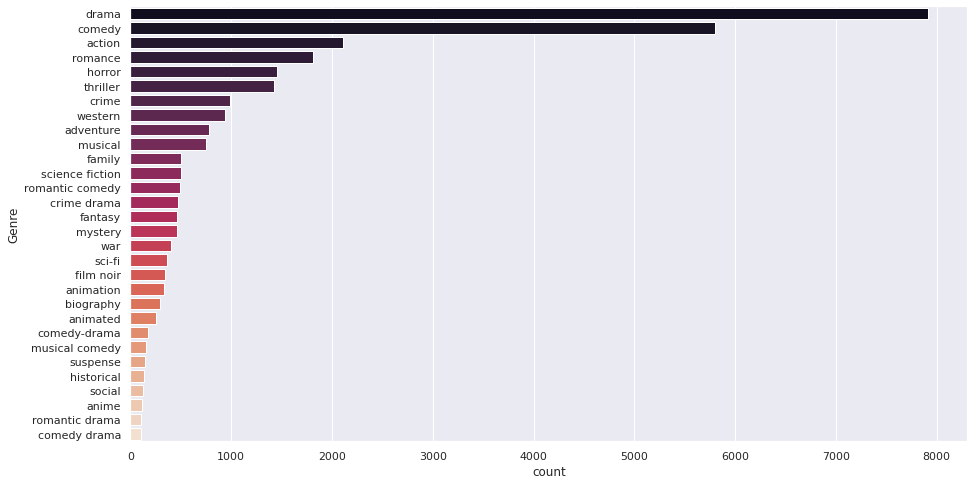

In [0]:
plt.figure(figsize=(15,8))
g = sf.groupby('GenreNorm', {'count':agg.COUNT()})
g = g.sort("count", ascending=False)
g = g.rename({"GenreNorm": "Genre"})
df = g.to_dataframe()
sns.barplot(y=df['Genre'], x=df["count"], palette="rocket")

In [0]:
from tqdm import tqdm
nlp = spacy.load('en_core_web_lg')
vector_list = []
for plot in tqdm(sf['Plot']):
    vector_list.append(nlp(plot).vector)
sf['vector'] = vector_list


100%|██████████| 29901/29901 [37:47<00:00, 13.19it/s]


In [0]:
train,test = sf.random_split(0.8)
cls = tc.classifier.create(train, features=["vector"], target="GenreNorm")

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 22554

Number of classes           : 30

Number of feature columns   : 1

Number of unpacked features : 300

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 15.078068    | 0.425911          | 0.306397            | 2.525588          | 2.769436            |

| 2         | 30.523999    | 0.474107          | 0.315657            | 2.205029          | 2.584302            |

| 3         | 46.062947    | 0.511262          | 0.320707            | 1.976241          | 2.456571            |

| 4         | 61.906581    | 0.540170          | 0.318182            | 1.800510          | 2.375503            |

| 5         | 77.606290    | 0.565576          | 0.320707            | 1.655809          | 2.312373            |

| 7         | 109.248977   | 0.606101          | 0.329125            | 1.436481          | 2.227321            |

| 8         | 125.292333   | 0.627428          | 0.333333            | 1.347615          | 2.198080            |

| 9         | 141.447559   | 0.644187          | 0.329966            | 1.270667          | 2.173420            |

| 10        | 157.544542   | 0.658331          | 0.324916            | 1.200714          | 2.154488            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 22554

Number of classes           : 30

Number of feature columns   : 1

Number of unpacked features : 300

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 12.415906    | 0.407511          | 0.314815            | 2.375931          | 3.024653            |

| 2         | 24.652149    | 0.442893          | 0.322391            | 2.044177          | 2.690830            |

| 3         | 36.887736    | 0.457835          | 0.335859            | 1.936861          | 2.600942            |

| 4         | 49.137329    | 0.463554          | 0.345118            | 1.886871          | 2.560058            |

| 5         | 61.348958    | 0.467323          | 0.344276            | 1.859837          | 2.527240            |

| 7         | 86.027567    | 0.472111          | 0.344276            | 1.832496          | 2.496447            |

| 8         | 98.185395    | 0.474461          | 0.345118            | 1.825527          | 2.489016            |

| 9         | 110.411225   | 0.475171          | 0.351010            | 1.818947          | 2.484006            |

| 10        | 122.740080   | 0.475969          | 0.346801            | 1.807856          | 2.479750            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 22554

Number of classes           : 30

Number of feature columns   : 1

Number of unpacked features : 300

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 15.121143    | 0.425911          | 0.306397            | 2.249199          | 3.029372            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 22554

Number of classes           : 30

Number of feature columns   : 1

Number of unpacked features : 300

Number of coefficients      : 8729

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 4        | 0.250000  | 1.395450     | 0.264255          | 0.275253            |

| 1         | 7        | 1.250000  | 2.872257     | 0.202625          | 0.194444            |

| 2         | 13       | 4.268741  | 5.389723     | 0.269531          | 0.276094            |

| 3         | 19       | 1.457422  | 7.899583     | 0.320298          | 0.323232            |

| 4         | 20       | 1.457422  | 8.709239     | 0.319766          | 0.313973            |

| 9         | 25       | 1.457422  | 12.694929    | 0.395008          | 0.384680            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.32491582491582494
PROGRESS: RandomForestClassifier          : 0.3468013468013468
PROGRESS: DecisionTreeClassifier          : 0.3063973063973064
PROGRESS: LogisticClassifier              : 0.3846801346801347
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.


In [0]:
e = cls.evaluate(test)
e

{'accuracy': 0.3935703848027277,
 'auc': 0.7958346348696606,
 'confusion_matrix': Columns:
 	target_label	str
 	predicted_label	str
 	count	int
 
 Rows: 248
 
 Data:
 +-----------------+-----------------+-------+
 |   target_label  | predicted_label | count |
 +-----------------+-----------------+-------+
 |      anime      |     romance     |   1   |
 |    historical   |      horror     |   2   |
 |     thriller    |       war       |   2   |
 |      action     |      crime      |   21  |
 |     mystery     |      comedy     |   15  |
 | romantic comedy |      drama      |   26  |
 |     suspense    |     thriller    |   4   |
 |     thriller    |      action     |   7   |
 |     thriller    |      crime      |   16  |
 |      family     |      action     |   5   |
 +-----------------+-----------------+-------+
 [248 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'f1_score': 0.145945

In [0]:
e['confusion_matrix'].sort('count', ascending=False).print_rows(100)

+-----------------+-----------------+-------+
|   target_label  | predicted_label | count |
+-----------------+-----------------+-------+
|      drama      |      drama      |  1079 |
|      comedy     |      comedy     |  647  |
|      comedy     |      drama      |  381  |
|      drama      |      comedy     |  265  |
|      horror     |      horror     |  197  |
|      action     |      drama      |  167  |
|     romance     |      drama      |  144  |
|     thriller    |      drama      |  121  |
|     romance     |     romance     |  118  |
|     western     |     western     |  118  |
|      drama      |     romance     |   99  |
|      crime      |      drama      |   70  |
|     musical     |      comedy     |   67  |
|    adventure    |      drama      |   67  |
|      action     |      action     |   65  |
|   crime drama   |      drama      |   59  |
|      action     |     thriller    |   56  |
|     musical     |      drama      |   53  |
|      comedy     |     romance   

It is important to remember that each movie can belong to several categories. Therefore, we need to evaluate our classifiers differently (or use multilabel classifiers). Nevertheless, we can see that our out-of-the-box classifier still obtains decent results. Let's visualize some of the results using t-SNE:

In [0]:
import numpy as np
from sklearn.manifold import TSNE

#Note: hopefully this code is correct... 
# The code was inspired from https://nlpforhackers.io/word-embeddings/
X = []
for v in sf['vector']:
    X.append(v)
X = np.array(X)
print("Computed X: ", X.shape)
X_embedded = TSNE(n_components=2, n_iter=250, verbose=2).fit_transform(X)
print("Computed t-SNE", X_embedded.shape)


Computed X:  (29901, 300)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 29901 samples in 1.328s...
[t-SNE] Computed neighbors for 29901 samples in 672.757s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29901
[t-SNE] Computed conditional probabilities for sample 2000 / 29901
[t-SNE] Computed conditional probabilities for sample 3000 / 29901
[t-SNE] Computed conditional probabilities for sample 4000 / 29901
[t-SNE] Computed conditional probabilities for sample 5000 / 29901
[t-SNE] Computed conditional probabilities for sample 6000 / 29901
[t-SNE] Computed conditional probabilities for sample 7000 / 29901
[t-SNE] Computed conditional probabilities for sample 8000 / 29901
[t-SNE] Computed conditional probabilities for sample 9000 / 29901
[t-SNE] Computed conditional probabilities for sample 10000 / 29901
[t-SNE] Computed conditional probabilities for sample 11000 / 29901
[t-SNE] Computed conditional probabilities for sample 12000 / 29901
[t-SNE] Computed condi

In [0]:
df = pd.DataFrame(columns=['x', 'y', 'Genre'])
df['x'], df['y'], df['Genre'] = X_embedded[:,0], X_embedded[:,1], sf['GenreNorm']
df

x         y            Genre
0      0.024448 -0.215919          western
1     -0.101338  0.350821           comedy
2      0.099214  0.022476           comedy
3     -0.007265  0.320439           comedy
4      0.011832 -0.008716            drama
...         ...       ...              ...
29896 -0.124538  0.104739            drama
29897 -0.320950  0.391061            drama
29898 -0.261507  0.047659           comedy
29899 -0.294214  0.342719           comedy
29900  0.087881  0.096559  romantic comedy

[29901 rows x 3 columns]

(-1.0, 1.0)

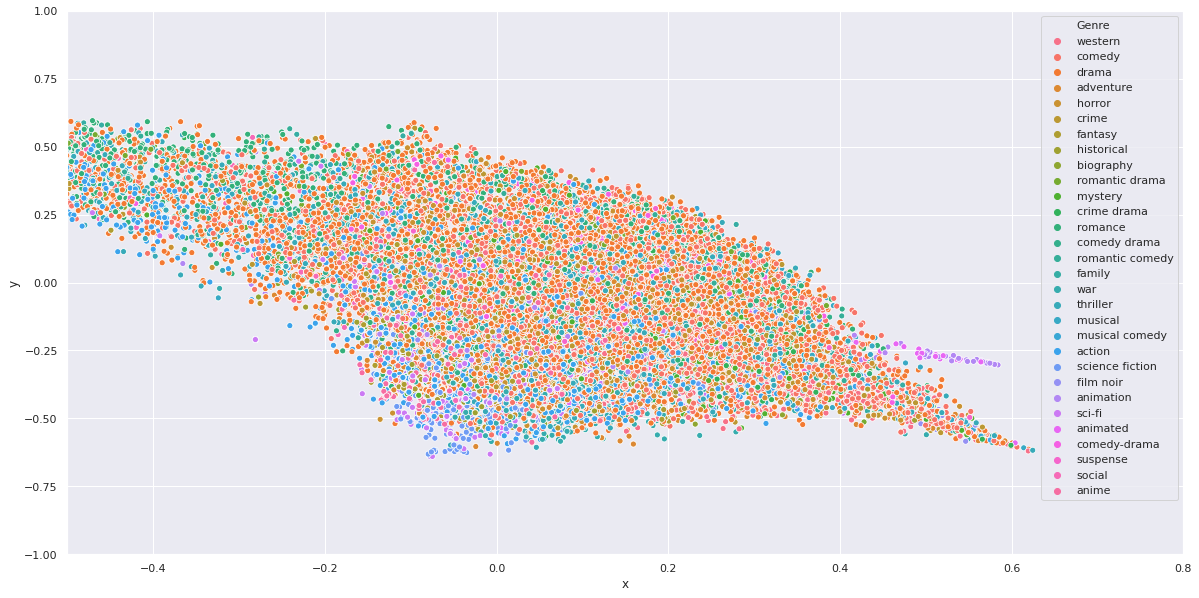

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
g_set = set(df['Genre'])
d = dict(zip(g_set, range(len(g_set))))
colors = [d[g] for g in df["Genre"]]


plt.figure(figsize=(20,10)) 
sns.scatterplot(x="x", y="y", hue="Genre", data=df)

plt.xlim(-0.5,0.8)
plt.ylim(-1,1)




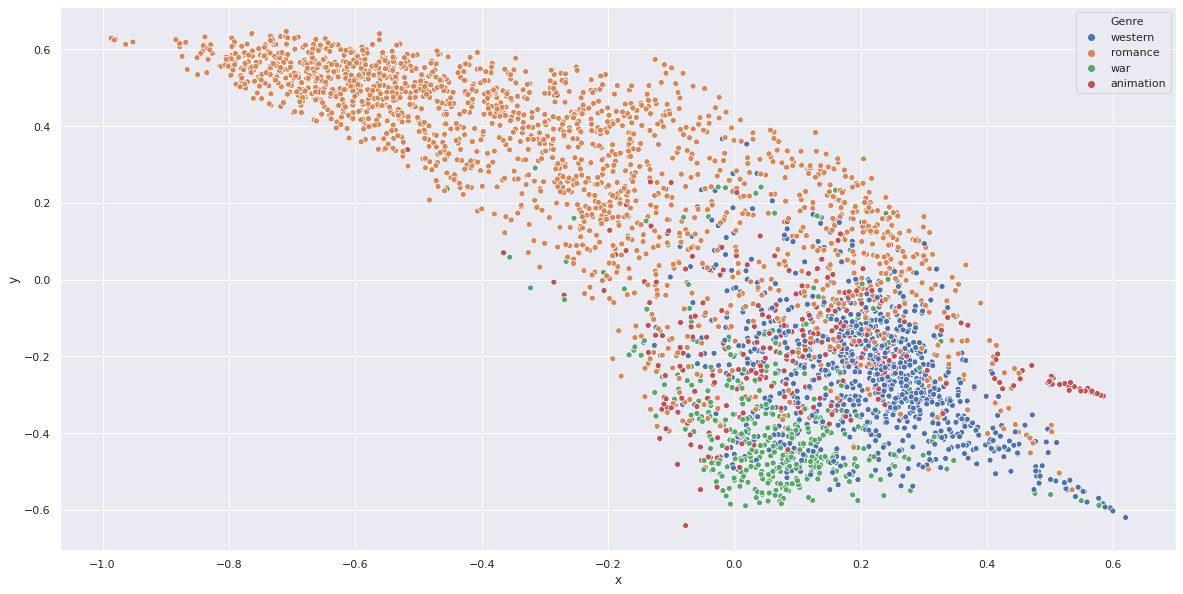

In [0]:
df2 = df[df["Genre"].apply(lambda g: g in {'war', "western", "romance","animation"})]
plt.figure(figsize=(20,10)) 
sns.scatterplot(x="x", y="y", hue="Genre", data=df2)

## Example 4: Analyzing the Works of Charles Dickens

Charles John Huffam Dickens (1812 - 1870) was an English writer. He created some of the world's best-known fictional characters, like Oliver Twist. Dickens is regarded by many as the greatest novelist of the Victorian era. In this example, we are going to analyze Dickens’ works by using NLP. We will use [The Works of Charles Dickens dataset](https://www.kaggle.com/fuzzyfroghunter/dickens#dickens.zip). Let's start by finding the main characters’ names in Oliver Twist:

In [0]:
import kaggle
!mkdir ./datasets
!mkdir ./datasets/dickens

# download the dataset from Kaggle and unzip it
!kaggle datasets download fuzzyfroghunter/dickens -p ./datasets/
!unzip ./datasets/dickens.zip  -d ./datasets/

dickens.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./datasets/dickens.zip
  inflating: ./datasets/dickens/1289-0.txt  
  inflating: ./datasets/dickens/1400-0.txt  
  inflating: ./datasets/dickens/1467-0.txt  
  inflating: ./datasets/dickens/27924-0.txt  
  inflating: ./datasets/dickens/564-0.txt  
  inflating: ./datasets/dickens/580-0.txt  
  inflating: ./datasets/dickens/644-0.txt  
  inflating: ./datasets/dickens/650-0.txt  
  inflating: ./datasets/dickens/653-0.txt  
  inflating: ./datasets/dickens/675-0.txt  
  inflating: ./datasets/dickens/678-0.txt  
  inflating: ./datasets/dickens/700-0.txt  
  inflating: ./datasets/dickens/766-0.txt  
  inflating: ./datasets/dickens/786-0.txt  
  inflating: ./datasets/dickens/807-0.txt  
  inflating: ./datasets/dickens/882-0.txt  
  inflating: ./datasets/dickens/883-0.txt  
  inflating: ./datasets/dickens/914-0.txt  
  inflating: ./datasets/dickens/917-0.txt  
  inflating: ./datasets/dickens

In [0]:
import spacy
nlp = spacy.load('en_core_web_lg')
datasets_path = "./datasets/dickens"
oliver_path = f"{datasets_path}/pg730.txt"


def get_entites_dict_from_text(text):
    entities_dict= {}
    #using spaCy to get entities
    doc = nlp(text)
    for entity in doc.ents:
        label = entity.label_
        e = entity.text.lower()
        if  label not in entities_dict:
            entities_dict[label] = {}
        if e not in entities_dict[label]:
            entities_dict[label][e] = 0
        entities_dict[label][e] += 1
    return entities_dict

def get_book_entities(path, person_min_times, other_entities_min_times=3):
    txt = open(path,"r", encoding="utf8", errors="ignore").read()
    txt = txt.replace("\n", " ")
    doc = nlp(txt)
    d = get_entites_dict_from_text(txt) 
    entities_dict = {}
    for k in d.keys():
        min_times = other_entities_min_times
        if k == "PERSON":
            min_times = person_min_times
        entity_dict = {k:v for k,v in d[k].items() if v>min_times}
        entities_dict[k] = entity_dict
    return entities_dict

entities_dict = get_book_entities(oliver_path, 20)
entities_dict

{'CARDINAL': {'a thousand': 4,
  'eleven': 4,
  'fifty': 7,
  'five': 6,
  'four': 13,
  'half': 62,
  'hundreds': 4,
  'one': 202,
  'only one': 4,
  'seven': 6,
  'six': 9,
  'ten': 7,
  'thousand': 4,
  'three': 42,
  'twenty': 8,
  'two': 172,
  'two or three': 4},
 'DATE': {'a day': 4,
  'a week': 5,
  'a year': 4,
  'all day': 7,
  'day': 6,
  'every day': 4,
  'last sunday': 4,
  'many years': 6,
  'next day': 9,
  'one day': 4,
  'sunday': 4,
  'the day': 23,
  'three months': 5,
  'year': 5,
  'years': 11,
  'yesterday': 10},
 'EVENT': {},
 'FAC': {'saffron hill': 4},
 'GPE': {'charlotte': 21,
  'london': 44,
  'pentonville': 6,
  'smithfield': 4,
  'the united states': 9},
 'LANGUAGE': {'english': 5},
 'LAW': {},
 'LOC': {'earth': 11},
 'MONEY': {'a penny': 4},
 'NORP': {'christian': 6, 'dodger': 65, 'jew': 312},
 'ORDINAL': {'first': 145, 'second': 26, 'third': 7},
 'ORG': {'chertsey': 6,
  'conkey': 4,
  'cripples': 6,
  'dodger': 12,
  'foundation': 9,
  'house': 6,
  'pro

By extracting only the entities, we can learn a lot about the book. Let's create a network among the book characters. A link in the network will be between two people that appeared in the same paragraph:

In [0]:
from tqdm import tqdm
txt = open(oliver_path).read()
paragraphs_list = txt.split("\n\n")
links_dict = {}

def get_persons_links(txt):
    links_set = set()
    doc = nlp(txt)
    l = [entity.text.lower().strip() for entity in doc.ents if entity.label_ == "PERSON"]
    
    for e1 in l:
        for e2 in l:
            if e1 == e2 or len(e1) < 2 or len(e2)< 2:
                continue
            if e1 > e2:
                e1, e2 = e2, e1 # switch order
            links_set.add((e1,e2))

    return links_set
links_list = []    
for para in tqdm(paragraphs_list):

    # for each paragraph each link counts only once
    links_list += list(get_persons_links(para))
    


100%|██████████| 4088/4088 [01:01<00:00, 66.03it/s]


In [0]:
from collections import Counter
import networkx as nx
c = Counter(links_list)
c.most_common(40)

[(('bumble', 'oliver'), 47),
 (('brownlow', 'oliver'), 41),
 (('oliver', 'sikes'), 34),
 (('fagin', 'sikes'), 31),
 (('nancy', 'sikes'), 29),
 (('bumble', 'corney'), 24),
 (('brittles', 'giles'), 23),
 (('bumble', 'mann'), 22),
 (('fagin', 'nancy'), 21),
 (('oliver', 'sowerberry'), 21),
 (('fagin', 'oliver'), 20),
 (('maylie', 'oliver'), 20),
 (('bumble', 'sowerberry'), 19),
 (('brownlow', 'grimwig'), 18),
 (('losberne', 'oliver'), 17),
 (('nancy', 'oliver'), 16),
 (('bill', 'fagin'), 16),
 (('noah', 'oliver'), 15),
 (('oliver', 'rose'), 15),
 (('giles', 'oliver'), 14),
 (('bedwin', 'brownlow'), 13),
 (('maylie', 'rose'), 13),
 (('harry', 'rose'), 13),
 (('bumble', 'noah'), 12),
 (('grimwig', 'oliver'), 11),
 (('charlotte', 'noah'), 11),
 (('bates', 'oliver'), 11),
 (('charley', 'fagin'), 11),
 (('bates', 'fagin'), 11),
 (('oliver', 'oliver twist'), 10),
 (('charley bates', 'oliver'), 10),
 (('bedwin', 'oliver'), 10),
 (('losberne', 'maylie'), 10),
 (('bolter', 'fagin'), 10),
 (('harry

We constructed the graph, and now let's visualize it:

In [0]:
g = nx.Graph()

for e,count in dict(c).items():
    if count < 6:
        # only links that appeared at least 6 times
        continue
    v1,v2 = e
    g.add_edge(v1,v2, weight=count)
nx.info(g)

'Name: \nType: Graph\nNumber of nodes: 32\nNumber of edges: 50\nAverage degree:   3.1250'

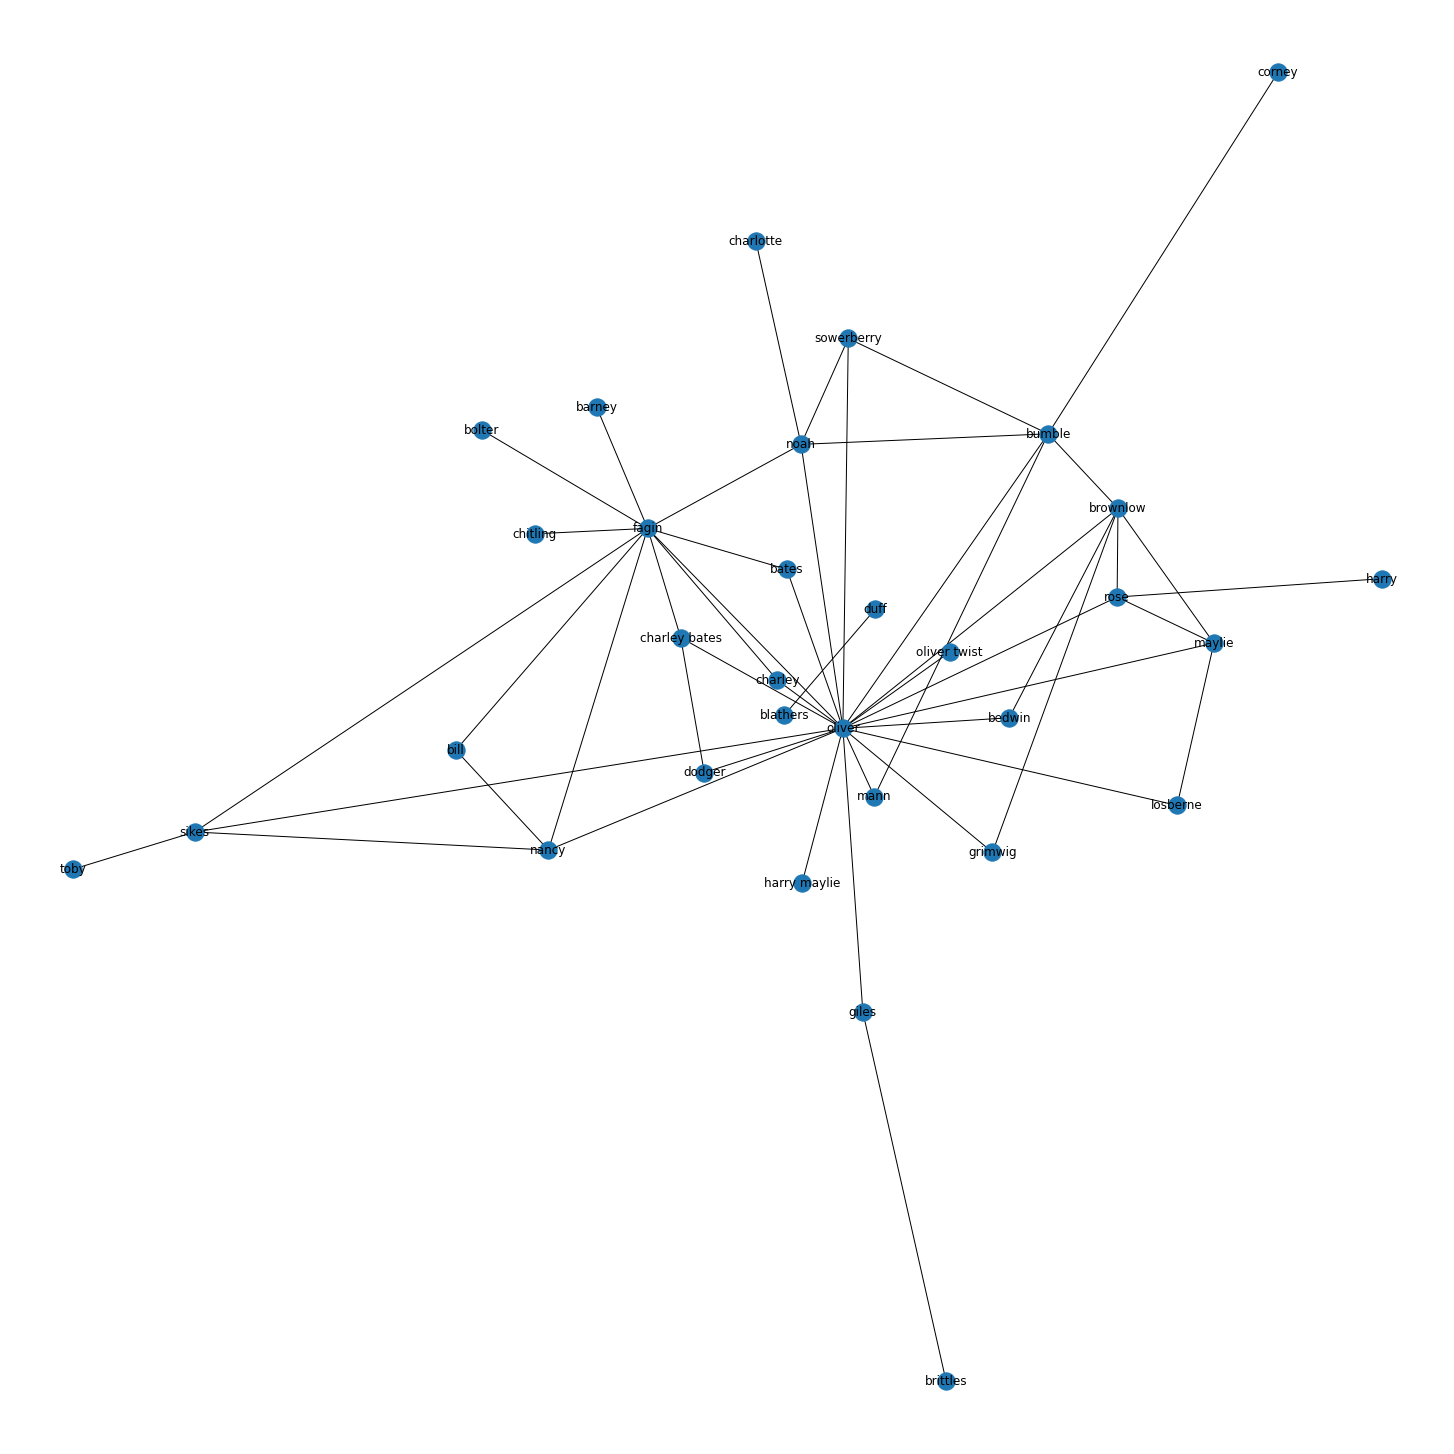

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,20))
nx.draw_kamada_kawai(g, with_labels=True)

Without reading the book, we can understand that Oliver Twist is the main character of the book, and we can also visualize his social network with its communities. For example, Mr. Bumble is connected to one part of the network, and Mr. Brownlow in another.

Let's try to find which of the Dickens books are the most similar to each other. First, let's create a word2vec model using Dickens texts:

In [0]:
import os
import nltk
from nltk.tokenize import word_tokenize

files = [p for p in os.listdir(datasets_path) if p.endswith(".txt")]

txt = ""
for p in files:
    txt += open(f"{datasets_path}/{p}").read()
print(f"Number of chars={len(txt)} and words={len(word_tokenize(txt))}")    
    

Number of chars=24350791 and words=5319562


In [0]:
import re
import gensim

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
re_words_split = re.compile("(\w+)")

def txt2words(s):
    s = re.sub("[^a-zA-Z]", " ", s).lower()
    return re_words_split.findall(s)

class Sentences(object):
        def __init__(self, txt):
            self._txt = txt
            
        def __iter__(self):
            for s in tokenizer.tokenize(self._txt):                                    
                yield txt2words(s)

# We will create a Word2Vec model based on Dickens work
sentences = Sentences(txt)
model = gensim.models.Word2Vec(sentences, size=200, window=5, min_count=3, workers=6)

In [0]:
model.wv.most_similar("oliver")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('barnaby', 0.7165127396583557),
 ('nicholas', 0.7140014171600342),
 ('sissy', 0.7107909321784973),
 ('kit', 0.6872396469116211),
 ('arabella', 0.6769044399261475),
 ('smike', 0.6760351657867432),
 ('trotty', 0.6692006587982178),
 ('hugh', 0.6529297828674316),
 ('noah', 0.6499978303909302),
 ('estella', 0.6481680870056152)]

According to the constructed model, we can see that Barnaby and Nicholas are the most similar to Oliver. According to [Wikipedia](https://en.wikipedia.org/wiki/Nicholas_Nickleby) "Dickens began writing Nickleby while still working on Oliver Twist." Let's calculate the average vector of each book:

In [0]:
import numpy as np

def txt2vector(txt):
    words = word_tokenize(txt)
    words = [w for w in words if w in model]
    if len(words) != 0:
        return np.mean([model[w] for w in words], axis=0)
    return None

vectors = [txt2vector(open(f"{datasets_path}/{p}").read()) for p in files]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [0]:
import turicreate as tc
sf = tc.SFrame({'Path': files, 'Vector':vectors})
meta_sf = tc.SFrame.read_csv(f"{datasets_path}/metadata.tsv", delimiter="\t")
sf = sf.join(meta_sf)
sf

Finished parsing file /content/datasets/dickens/metadata.tsv

Parsing completed. Parsed 32 lines in 0.012438 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/datasets/dickens/metadata.tsv

Parsing completed. Parsed 32 lines in 0.01108 secs.

Columns:
	Path	str
	Vector	ndarray
	Title	str

Rows: 32

Data:
+-------------+-------------------------------+-------------------------------+
|     Path    |             Vector            |             Title             |
+-------------+-------------------------------+-------------------------------+
|  924-0.txt  | [ 0.18693389 -0.05817534  ... |       To be Read at Dusk      |
|  pg1392.txt | [ 2.52328187e-01 -8.835683... |   The Seven Poor Travellers   |
|  580-0.txt  | [ 0.09717834 -0.0575846  -... |      The Pickwick Papers      |
|  pg1407.txt | [ 1.33930400e-01 -5.356890... |     A Message from the Sea    |
|  700-0.txt  | [ 0.17739967 -0.11101954 -... |     The Old Curiosity Shop    |
|  650-0.txt  | [ 0.2700772  -0.09546367  ... |      Pictures from Italy      |
| pg23344.txt | [ 1.36031166e-01 -1.068413... | The Magic Fishbone A Holid... |
|   98-0.txt  | [ 0.21643361 -0.08332978 -... | A Tale of Two Cities A Sto... |
|  967-0.txt  | [ 1.28833309e-01 -7.220972... | The Life And Adventures Of... |
|  963-0.txt  | [ 0.1827627  -0.07022326 -... |         Little Dorrit         |
+-------------+-------------------------------+-------------------------------+
[32 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [0]:
meta_sf.print_rows(33)

+-------------+-------------------------------+
|     Path    |             Title             |
+-------------+-------------------------------+
|  924-0.txt  |       To be Read at Dusk      |
|  pg1392.txt |   The Seven Poor Travellers   |
|  580-0.txt  |      The Pickwick Papers      |
|  pg1407.txt |     A Message from the Sea    |
|  700-0.txt  |     The Old Curiosity Shop    |
|  650-0.txt  |      Pictures from Italy      |
| pg23344.txt | The Magic Fishbone A Holid... |
|   98-0.txt  | A Tale of Two Cities A Sto... |
|  967-0.txt  | The Life And Adventures Of... |
|  963-0.txt  |         Little Dorrit         |
|  914-0.txt  |   The Uncommercial Traveller  |
|  pg730.txt  |          Oliver Twist         |
|  1289-0.txt |      Three Ghost Stories      |
|  653-0.txt  |           The Chimes          |
| 27924-0.txt |         Mugby Junction        |
|  1400-0.txt |       Great Expectations      |
|  pg676.txt  |       The Battle of Life      |
|  766-0.txt  |       David Copperfield 

In [0]:
from sklearn.manifold import TSNE

#Note: hopefully this code is correct... 
# The code was inspired from https://nlpforhackers.io/word-embeddings/
X = []
for v in sf['Vector']:
    X.append(v)
X = np.array(X)
print("Computed X: ", X.shape)
X_embedded = TSNE(n_components=2, n_iter=250, verbose=2).fit_transform(X)
print("Computed t-SNE", X_embedded.shape)

Computed X:  (32, 200)
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 32 samples in 0.000s...
[t-SNE] Computed neighbors for 32 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 32 / 32
[t-SNE] Mean sigma: 1.134775
[t-SNE] Computed conditional probabilities in 0.018s
[t-SNE] Iteration 50: error = 45.0215034, gradient norm = 0.5765978 (50 iterations in 0.015s)
[t-SNE] Iteration 100: error = 48.7129250, gradient norm = 0.5061362 (50 iterations in 0.016s)
[t-SNE] Iteration 150: error = 45.8762703, gradient norm = 0.4169826 (50 iterations in 0.015s)
[t-SNE] Iteration 200: error = 42.5768242, gradient norm = 0.6390978 (50 iterations in 0.015s)
[t-SNE] Iteration 250: error = 46.0309219, gradient norm = 0.4135205 (50 iterations in 0.015s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.030922
[t-SNE] KL divergence after 251 iterations: 1797693134862315708145274237317043567980705675258449965989174768031572607800285387605895586327668781

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


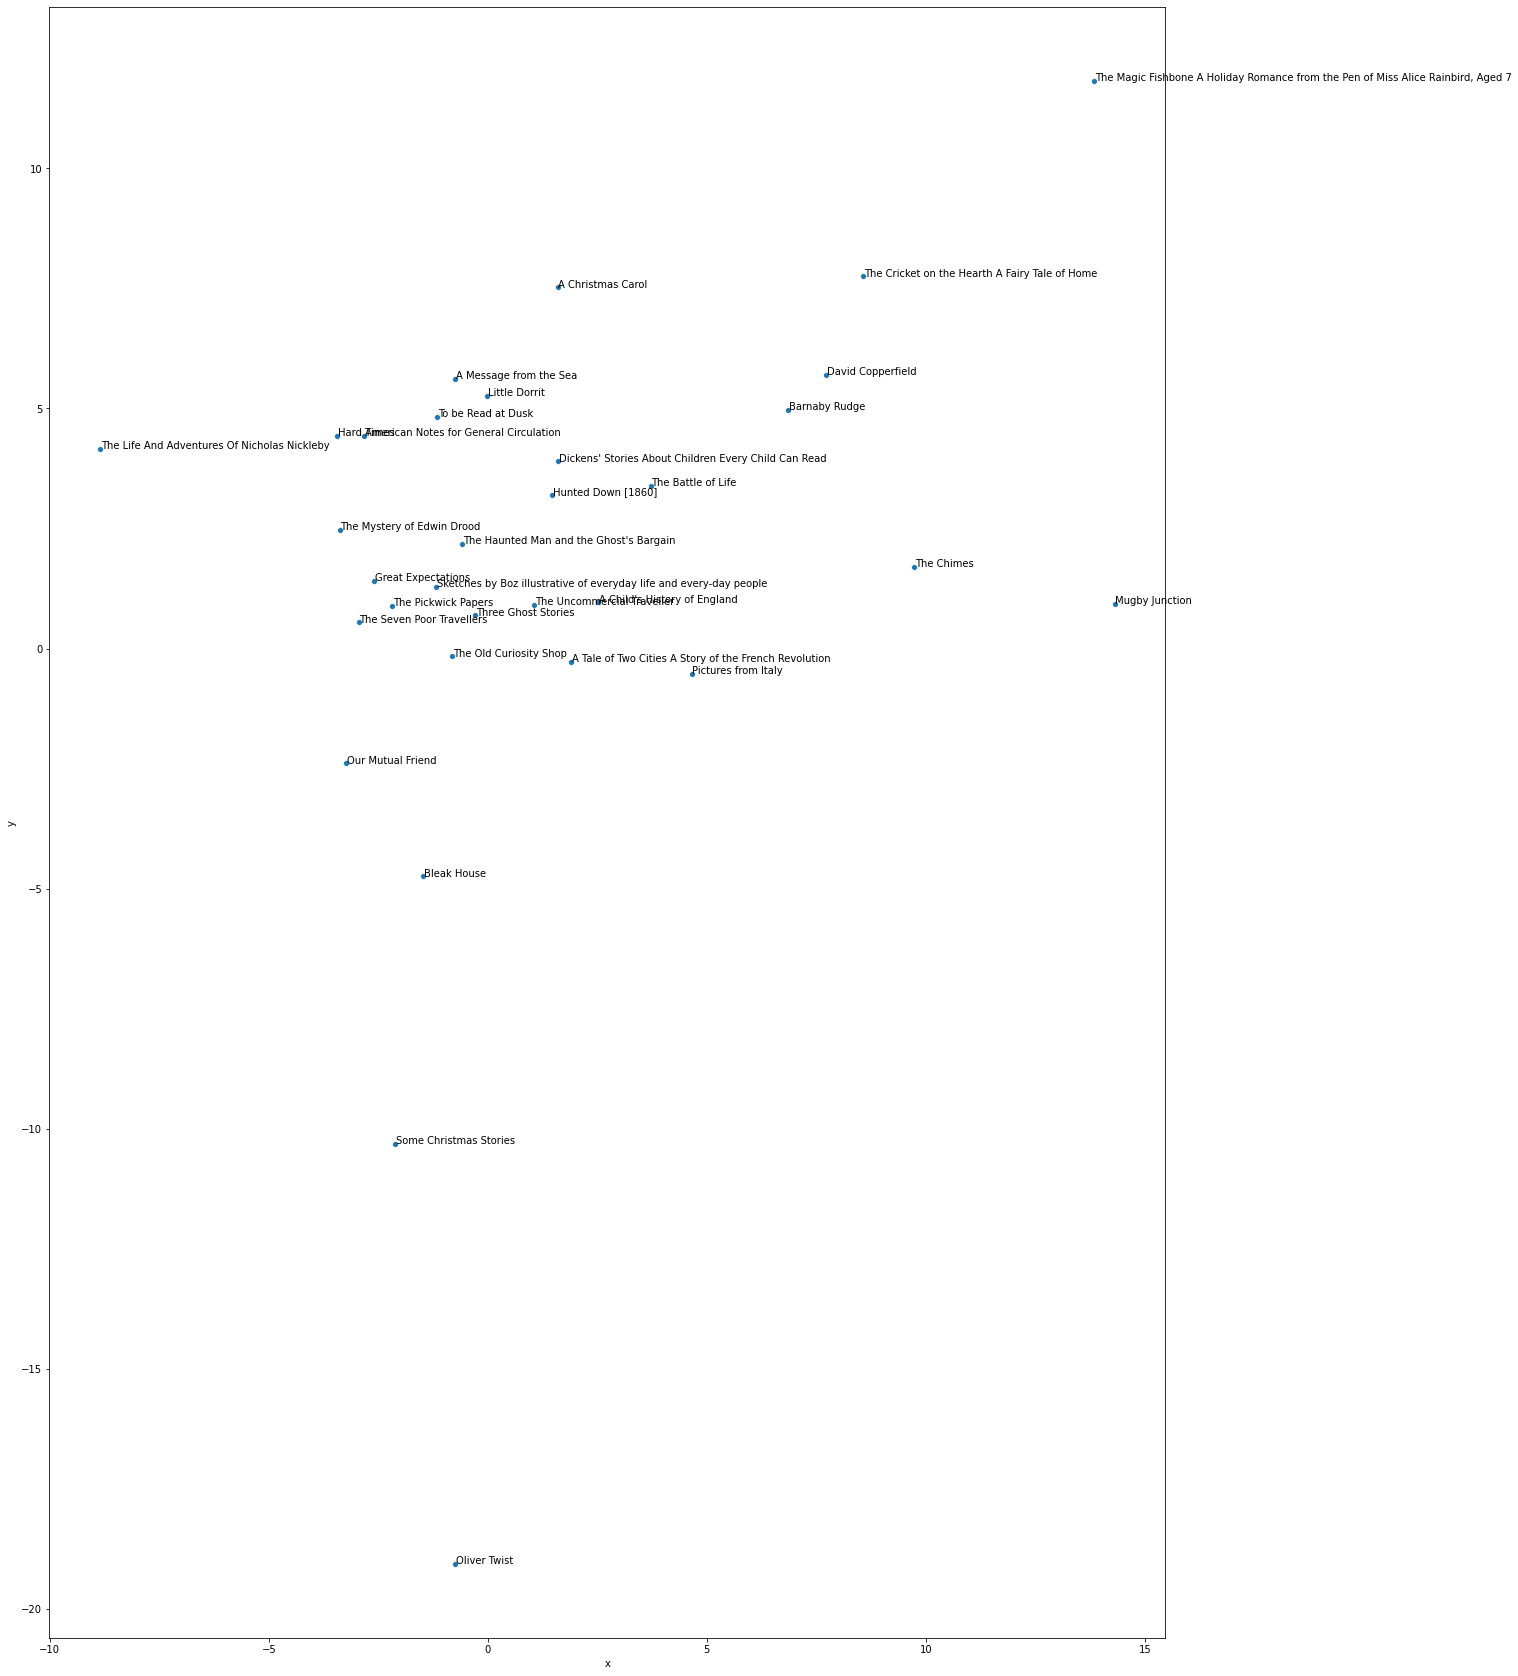

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame(columns=['x', 'y', 'Title'])
df['x'], df['y'], df['Title'] = X_embedded[:,0], X_embedded[:,1], sf['Title']
g_set = set(df['Title'])
d = dict(zip(g_set, range(len(g_set))))
colors = [d[g] for g in df["Title"]]
plt.figure(figsize=(20,30)) 
sns.scatterplot(x="x", y="y", data=df)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(df['x'], df['y'], df['Title'], plt.gca())



From the above results, we can see that _Oliver Twist_ is some what an outlier.


## Example 5: Oscars Speeches

In this example, we are going to explore the Oscars speeches over the last 80 years. Let's start by loading the
[Oscars Speeches dataset](https://www.kaggle.com/cerosdotcom/oscars-speeches) into an SFrame object:


In [0]:
import kaggle
!mkdir ./datasets
!mkdir ./datasets/oscar_speech

# download the dataset from Kaggle and unzip it
!kaggle datasets download cerosdotcom/oscars-speeches -p ./datasets/oscar_speech
!unzip ./datasets/oscar_speech/*.zip  -d ./datasets/oscar_speech

mkdir: cannot create directory ‘./datasets’: File exists
  0% 0.00/523k [00:00<?, ?B/s]
100% 523k/523k [00:00<00:00, 36.1MB/s]
Archive:  ./datasets/oscar_speech/oscars-speeches.zip
  inflating: ./datasets/oscar_speech/oscar_speech_db.csv  


In [0]:
import turicreate as tc
import turicreate.aggregate as agg
import pandas as pd
%matplotlib inline

oscar_speeces_dataset = "./datasets/oscar_speech/oscar_speech_db.csv"
df = pd.read_csv(oscar_speeces_dataset)
df

Year  ...                                             Speech
0     1939 (12th) Academy Awards  ...   VIVIEN LEIGH:\r\nLadies and gentlemen, please...
1     1939 (12th) Academy Awards  ...   HATTIE McDANIEL:\r\nAcademy of Motion Picture...
2     1941 (14th) Academy Awards  ...   DONALD CRISP:\r\nLadies and gentlemen, it's a...
3     1941 (14th) Academy Awards  ...   JOAN FONTAINE:\r\nI want to thank the ladies ...
4     1941 (14th) Academy Awards  ...   MARY ASTOR:\r\nLadies and gentlemen, twenty-t...
...                          ...  ...                                                ...
1664  2016 (89th) Academy Awards  ...   KENNETH LONERGAN:\r\nThank you so much. I lov...
1665  2016 (89th) Academy Awards  ...   JACKIE CHAN:\r\nAcademy Award! I still can't ...
1666  2016 (89th) Academy Awards  ...   ANNE V. COATES:\r\nThank you, thank you, than...
1667                        None  ...                                               None
1668  2016 (89th) Academy Awards  ...   FREDERICK WISEMAN:\r\nThank you. Thank you. I...

[1669 rows x 7 columns]

In [0]:
import re
from nltk.tokenize import word_tokenize

sf = tc.SFrame(df[['Year', 'Category', 'Speech']])
r_year = re.compile(r"\d{4}")
sf['Year'] = sf['Year'].apply(lambda s: r_year.findall(s))
sf['Year'] = sf['Year'].apply(lambda l: int(l[0]) if len(l) > 0 else None)
sf['Chars Number'] = sf['Speech'].apply(lambda s: len(s))
sf['Words Number'] = sf['Speech'].apply(lambda s: len(word_tokenize(s)))
sf  

Columns:
	Year	int
	Category	str
	Speech	str
	Chars Number	int
	Words Number	int

Rows: 1669

Data:
+------+-------------------------------+-------------------------------+--------------+
| Year |            Category           |             Speech            | Chars Number |
+------+-------------------------------+-------------------------------+--------------+
| 1939 |            Actress            |  VIVIEN LEIGH:\r\nLadies a... |     529      |
| 1939 |  Actress in a Supporting Role |  HATTIE McDANIEL:\r\nAcade... |     602      |
| 1941 |   Actor in a Supporting Role  |  DONALD CRISP:\r\nLadies a... |     804      |
| 1941 |            Actress            |  JOAN FONTAINE:\r\nI want ... |     232      |
| 1941 |  Actress in a Supporting Role |  MARY ASTOR:\r\nLadies and... |     238      |
| 1941 |           Directing           |  COL. DARRYL F. ZANUCK:\r\... |     471      |
| 1941 |  Documentary (Short Subject)  |  JOHN GRIERSON:\r\nI shall... |     174      |
| 1941 | Writing (Original Screenplay) |  GEORGE SCHAEFER:\r\nMr. H... |     253      |
| 1941 |    Writing (Original Story)   |  HARRY SEGALL:\r\n[No spee... |      29      |
| 1941 |      Writing (Screenplay)     |  SETON I. MILLER:\r\n[No s... |      32      |
+------+-------------------------------+-------------------------------+--------------+
+--------------+
| Words Number |
+--------------+
|     111      |
|     134      |
|     176      |
|      53      |
|      52      |
|      98      |
|      35      |
|      54      |
|      8       |
|      9       |
+--------------+
[1669 rows x 5 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

Now, to better understand the data, let's visualize various speech statistics. For the visualization,
we will use the [Plotly-Express](https://medium.com/@plotlygraphs/introducing-plotly-express-808df010143d) package:

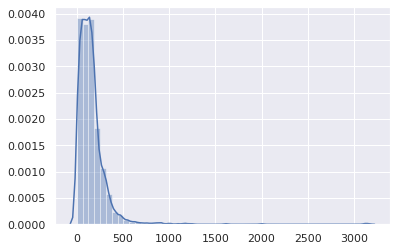

In [0]:
import seaborn as sns
sns.set()
sns.distplot(sf['Words Number'])

In [0]:
import plotly_express as px
import turicreate.aggregate as agg


g = sf.groupby("Year", {'Words AVG': agg.AVG('Words Number')})
g = g.sort('Year')
px.line(g.to_dataframe(), x="Year", y="Words AVG")


In [0]:
g = sf.groupby("Category", {'count': agg.COUNT()})
g = g[g["count"] >= 40]
selected_categories_set = set(g["Category"])
sf2 = sf[sf['Category'].apply(lambda c: c in selected_categories_set)]

g = sf2.groupby(["Year",'Category'], {'Words AVG': agg.AVG('Words Number')})
g = g.sort(['Year','Category'])
px.line(g.to_dataframe(), x="Year", y="Words AVG", color="Category")



We can see that on average the speech lengths increased over time, especially  _Honorary Award_ speeches in recent years. 
Let's try to find the different topics of the speeches:

In [0]:

docs = tc.text_analytics.count_ngrams(sf['Speech'], n=1, method="word")
docs = docs.dict_trim_by_keys(tc.text_analytics.stop_words(lang='en'), exclude=True)
topic_model = tc.topic_model.create(docs, num_topics=30)
topic_model.get_topics().print_rows(100)

Learning a topic model

Number of documents      1669

Vocabulary size     13932

Running collapsed Gibbs sampling

+-----------+---------------+----------------+-----------------+

| Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |

+-----------+---------------+----------------+-----------------+

| 10        | 197.506ms     | 4.30601e+06    | 0               |

+-----------+---------------+----------------+-----------------+

+-------+------------+----------------------+
| topic |    word    |        score         |
+-------+------------+----------------------+
|   0   |     –      | 0.047876618676107006 |
|   0   |   thing    | 0.033197940963566853 |
|   0   |    don     | 0.024350518780665933 |
|   0   |    kind    | 0.01590525215153324  |
|   0   |  thought   | 0.012486929944503341 |
|   1   |   happy    | 0.027960690412050772 |
|   1   |    make    | 0.02596527985632904  |
|   1   |  producer  | 0.019979048189163844 |
|   1   |    bob     | 0.01523994811932473  |
|   1   |  academy   | 0.013244537563602998 |
|   2   |     ve     | 0.034026148172979755 |
|   2   |    love    | 0.03043436617020216  |
|   2   | wonderful  | 0.02301135003112846  |
|   2   |    film    | 0.016067238159091776 |
|   2   |    life    | 0.013672716823906715 |
|   3   |   people   | 0.029311872415827965 |
|   3   |  academy   | 0.027835203780269883 |
|   3   |    life    | 0.018482969088402017 |
|   3   |    wife    | 0.017498523

Let's try to create a classifier that predicts if the winner is a male or female according to his/her speech:

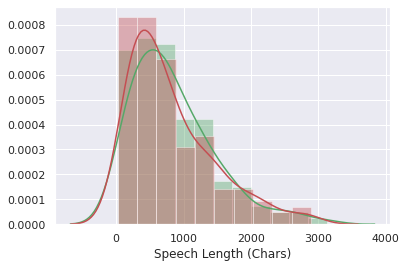

In [0]:
g_sf = sf[sf['Category'].apply(lambda c: 'Actor' in c or 'Actress' in c)]
def get_gender(c):
    if 'actor' in c.lower():
        return 'Male'
    if 'actress' in c.lower():
        return 'Female'
    return None
g_sf['Gender'] = g_sf['Category'].apply(lambda c: get_gender(c))
sns.distplot(g_sf[g_sf['Gender'] == 'Male']['Chars Number'], axlabel="Speech Length (Chars)", color='g')
sns.distplot(g_sf[g_sf['Gender'] == 'Female']['Chars Number'], axlabel="Speech Length (Chars)", color='r')

In [0]:
g_sf['bow'] = tc.text_analytics.count_words(g_sf['Speech'])
train,test = g_sf.random_split(0.7)
cls = tc.logistic_classifier.create(train, features=['bow'], target='Gender')

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Logistic regression:

--------------------------------------------------------

Number of examples          : 202

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 4234

Number of coefficients      : 4235

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.016093     | 0.990099          | 0.636364            |

| 1         | 4        | 1.000000  | 0.022975     | 1.000000          | 0.727273            |

| 2         | 6        | 1.000000  | 0.029951     | 1.000000          | 0.636364            |

| 3         | 8        | 1.000000  | 0.036525     | 1.000000          | 0.636364            |

| 4         | 10       | 1.000000  | 0.042437     | 1.000000          | 0.636364            |

| 9         | 19       | 1.000000  | 0.068883     | 1.000000          | 0.545455            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

In [0]:
cls.evaluate(test)

{'accuracy': 0.7105263157894737,
 'auc': 0.7501742160278745,
 'confusion_matrix': Columns:
 	target_label	str
 	predicted_label	str
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |    Female    |       Male      |   12  |
 |     Male     |      Female     |   10  |
 |     Male     |       Male      |   25  |
 |    Female    |      Female     |   29  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.6944444444444444,
 'log_loss': 0.7857802952310606,
 'precision': 0.6756756756756757,
 'recall': 0.7142857142857143,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+--------------------+-----+----+----+
 | threshold |        fpr         | tpr | p  | n  |
 +-----------+--------------------+-----+----+----+
 |    0.0    |        1.0         | 1.0 | 35 | 41 |
 |   1e-05   | 0

Let's create a classifier to predict the speech's decade:

In [0]:
import spacy
nlp = spacy.load('en_core_web_lg')

sf['Decade'] = sf['Year'].apply(lambda y: y - y %10)
vectors = []
for s in sf['Speech']:
    vectors.append(nlp(s).vector)
sf['Vector'] = vectors
sf = sf.dropna()
train,test = sf.random_split(0.8)
cls = tc.classifier.create(train, features=['Vector'], target='Decade')

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 1260

Number of classes           : 9

Number of feature columns   : 1

Number of unpacked features : 300

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.369397     | 0.780952          | 0.223881            | 1.657736          | 2.113310            |

| 2         | 0.724193     | 0.906349          | 0.268657            | 1.306611          | 2.025100            |

| 3         | 1.080036     | 0.943651          | 0.238806            | 1.083165          | 2.008395            |

| 4         | 1.433570     | 0.965873          | 0.268657            | 0.891861          | 1.957004            |

| 5         | 1.794807     | 0.971429          | 0.268657            | 0.754547          | 1.927188            |

| 10        | 3.532876     | 0.986508          | 0.313433            | 0.345847          | 1.838566            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 1260

Number of classes           : 9

Number of feature columns   : 1

Number of unpacked features : 300

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.289058     | 0.667460          | 0.283582            | 1.103309          | 2.100184            |

| 2         | 0.585930     | 0.804762          | 0.238806            | 0.944122          | 2.032504            |

| 3         | 0.864031     | 0.855556          | 0.298507            | 0.901682          | 2.011477            |

| 4         | 1.139936     | 0.886508          | 0.328358            | 0.885497          | 1.957222            |

| 5         | 1.421155     | 0.915079          | 0.328358            | 0.872366          | 1.898834            |

| 10        | 2.772782     | 0.952381          | 0.417910            | 0.840091          | 1.833471            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 1260

Number of classes           : 9

Number of feature columns   : 1

Number of unpacked features : 300

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.364929     | 0.780952          | 0.223881            | 0.907378          | 2.336624            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 1260

Number of classes           : 9

Number of feature columns   : 1

Number of unpacked features : 300

Number of coefficients      : 2408

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 3        | 0.500000  | 0.075750     | 0.246825          | 0.238806            |

| 1         | 5        | 0.500000  | 0.126970     | 0.329365          | 0.268657            |

| 2         | 6        | 0.625000  | 0.172116     | 0.366667          | 0.298507            |

| 3         | 7        | 0.781250  | 0.216040     | 0.345238          | 0.253731            |

| 4         | 8        | 0.976563  | 0.256525     | 0.385714          | 0.313433            |

| 9         | 13       | 1.000000  | 0.449382     | 0.423016          | 0.298507            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.31343283582089554
PROGRESS: RandomForestClassifier          : 0.417910447761194
PROGRESS: DecisionTreeClassifier          : 0.22388059701492538
PROGRESS: LogisticClassifier              : 0.29850746268656714
PROGRESS: ---------------------------------------------
PROGRESS: Selecting RandomForestClassifier based on validation set performance.


In [0]:
e = cls.evaluate(test)
e

{'accuracy': 0.3385093167701863, 'auc': nan, 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 51
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |     1990     |       1960      |   3   |
 |     2000     |       2010      |   5   |
 |     2000     |       1960      |   6   |
 |     1990     |       1980      |   5   |
 |     1960     |       1950      |   2   |
 |     1960     |       2000      |   2   |
 |     2010     |       1950      |   1   |
 |     1980     |       1960      |   10  |
 |     1950     |       1970      |   8   |
 |     2000     |       1990      |   11  |
 +--------------+-----------------+-------+
 [51 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns., 'f1_score': 0.2830923398462295, 'log_loss': 1.8350438604892183, 'precision': 0.301

In [0]:
e['confusion_matrix'].sort('count', ascending=False)

Columns:
	target_label	int
	predicted_label	int
	count	int

Rows: 51

Data:
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|     1960     |       1960      |   38  |
|     1970     |       1960      |   19  |
|     2000     |       2000      |   17  |
|     1990     |       1990      |   16  |
|     2010     |       2010      |   14  |
|     1970     |       1980      |   14  |
|     1980     |       1970      |   12  |
|     2000     |       1990      |   11  |
|     1980     |       1980      |   11  |
|     2010     |       2000      |   11  |
+--------------+-----------------+-------+
[51 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [0]:
from sklearn.decomposition import PCA
import numpy as np

#Important Note: This is non-final code that may have mistakes
X = []
for v in sf['Vector']:
    X.append(v)
X = np.array(X)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
df

principal component 1  principal component 2
0                 -0.298224               0.152252
1                 -0.471784               0.204497
2                 -0.515947               0.074225
3                 -0.091089              -0.273873
4                 -0.263723               0.005234
...                     ...                    ...
1644              -0.317292              -0.018792
1645              -0.240787              -0.110080
1646              -0.304782               0.022003
1647              -0.368265               0.000478
1648              -0.521728               0.261314

[1649 rows x 2 columns]

In [0]:
df = pd.concat([df, sf[['Decade']].to_dataframe()], axis = 1)
px.scatter(df, x='principal component 1', y='principal component 2', color="Decade")

In [0]:
pca = PCA(n_components=3)
pcaComp = pca.fit_transform(X)
df = pd.DataFrame(data = pcaComp, columns = ['PCA1', 'PCA2', 'PCA3'])

df = pd.concat([df, sf[['Decade']].to_dataframe()], axis = 1)
px.scatter_3d(df, x="PCA1", y="PCA2",z="PCA3", color="Decade")


## Example 6: Twitter Trolls Detection

In this example, we are going to identify aggressive  tweets using the [Tweets Dataset for Detection of Cyber-Trolls](https://www.kaggle.com/dataturks/dataset-for-detection-of-cybertrolls).
Let's start by loading the dataset into an SFrame object:


In [0]:
!mkdir ./datasets
!mkdir ./datasets/trolls

# download the dataset from Kaggle and unzip it
!kaggle datasets download dataturks/dataset-for-detection-of-cybertrolls -p ./datasets/trolls
!unzip ./datasets/trolls/*.zip  -d ./datasets/trolls/

  0% 0.00/670k [00:00<?, ?B/s]
100% 670k/670k [00:00<00:00, 92.2MB/s]
Archive:  ./datasets/trolls/dataset-for-detection-of-cybertrolls.zip
  inflating: ./datasets/trolls/Dataset for Detection of Cyber-Trolls.json  


In [0]:
import turicreate as tc
import turicreate.aggregate as agg
dataset_path = "./datasets/trolls/Dataset for Detection of Cyber-Trolls.json"
sf = tc.SFrame.read_json(dataset_path, orient="lines")
sf = sf.unpack('annotation')
sf = sf.rename({'annotation.label':'label'})
sf

Finished parsing file /content/datasets/trolls/Dataset for Detection of Cyber-Trolls.json

Parsing completed. Parsed 100 lines in 0.098584 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/datasets/trolls/Dataset for Detection of Cyber-Trolls.json

Parsing completed. Parsed 20001 lines in 0.099112 secs.

Columns:
	content	str
	extras	float
	label	list
	annotation.notes	str

Rows: 20001

Data:
+-------------------------------+--------+-------+------------------+
|            content            | extras | label | annotation.notes |
+-------------------------------+--------+-------+------------------+
|     Get fucking real dude.    |  None  |  [1]  |                  |
|  She is as dirty as they c... |  None  |  [1]  |                  |
|  why did you fuck it up. I... |  None  |  [1]  |                  |
|  Dude they dont finish enc... |  None  |  [1]  |                  |
|  WTF are you talking about... |  None  |  [1]  |                  |
| Ill save you the trouble s... |  None  |  [1]  |                  |
|  Im dead serious.Real athl... |  None  |  [1]  |                  |
| ...go absolutely insane.ha... |  None  |  [1]  |                  |
| Lmao  im watching the same... |  None  |  [1]  |                  |
| LOL  no he said  What do y... |  None  |  [1]  |                  |
+-------------------------------+--------+-------+------------------+
[20001 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [0]:
sf['label'] = sf['label'].apply(lambda l: int(l[0]))
sf.groupby('label', {'count':agg.COUNT()})

Columns:
	label	int
	count	int

Rows: 2

Data:
+-------+-------+
| label | count |
+-------+-------+
|   0   | 12179 |
|   1   |  7822 |
+-------+-------+
[2 rows x 2 columns]

Let's find the most common words in aggressive tweets:

In [0]:
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *

stop_words_set = set(stopwords.words("english"))
stemmer = PorterStemmer()

#Using cahcing for faster performence
def word_stemming(w):
    return stemmer.stem(w)


def skip_word(w):
    w = w.lower()
    if len(w) <2:
        return True
    if w.isdigit():
        return True
    if w in stop_words_set or stemmer.stem(w) in stop_words_set:
        return True
    return False


txt = "\n".join(sf[sf['label'] == 1]['content'])
l = [w.lower() for w in word_tokenize(txt) if not skip_word(w)]
c = Counter(l)
c.most_common(20)


[('...', 1598),
 ('hate', 1308),
 ('damn', 1083),
 ('fuck', 1036),
 ('ass', 1025),
 ("'s", 981),
 ("n't", 841),
 ('sucks', 697),
 ('fucking', 631),
 ('lol', 560),
 ("'m", 537),
 ('bitch', 499),
 ('like', 497),
 ("''", 477),
 ('``', 448),
 ('get', 447),
 ('gay', 416),
 ('know', 371),
 ('fat', 287),
 ("'re", 282)]

Let's use spaCy to classify the tweets:

In [0]:
import spacy
from tqdm import tqdm

nlp = spacy.load('en_core_web_lg')
vectors = []
for t in tqdm(sf['content']):
    vectors.append(nlp(t).vector)

sf['vector'] = vectors
train,test = sf.random_split(0.8)
cls = tc.classifier.create(train, features=['vector'],target='label')

100%|██████████| 20001/20001 [02:38<00:00, 125.87it/s]


PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: LogisticClassifier, SVMClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Logistic regression:

--------------------------------------------------------

Number of examples          : 15271

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 300

Number of coefficients      : 301

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 3.693945     | 0.720058          | 0.685323            |

| 2         | 3        | 5.182620     | 0.727719          | 0.699005            |

| 3         | 4        | 6.662378     | 0.726475          | 0.694030            |

| 4         | 5        | 8.130091     | 0.727064          | 0.695274            |

| 5         | 6        | 9.608757     | 0.726933          | 0.695274            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

SVM:

--------------------------------------------------------

Number of examples          : 15271

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 300

Number of coefficients    : 301

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 5        | 0.050498  | 0.669120     | 0.613123          | 0.568408            |

| 1         | 7        | 0.050498  | 1.068037     | 0.613974          | 0.568408            |

| 2         | 8        | 0.063122  | 1.317978     | 0.614433          | 0.569652            |

| 3         | 12       | 1.325563  | 1.975365     | 0.658045          | 0.609453            |

| 4         | 13       | 1.325563  | 2.241768     | 0.675791          | 0.635572            |

| 9         | 20       | 1.325563  | 3.795504     | 0.706633          | 0.660448            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: LogisticClassifier              : 0.695273631840796
PROGRESS: SVMClassifier                   : 0.6604477611940298
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.


In [0]:
cls.evaluate(test)

{'accuracy': 0.7091186958736627,
 'auc': 0.7894525876982023,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        1        |  815  |
 |      1       |        0        |  724  |
 |      0       |        1        |  418  |
 |      0       |        0        |  1969 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.588023088023088,
 'log_loss': 0.5377973530537218,
 'precision': 0.6609894566098946,
 'recall': 0.5295646523716699,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+--------------------+-----+------+------+
 | threshold |        fpr         | tpr |  p   |  n   |
 +-----------+--------------------+-----+------+------+
 |    0.0    |        1.0         | 1.0 | 1539 | 2387 |
 

Let's try to improve the results by using pre-trained word vectors from Twitter:


In [0]:
import gensim.downloader as api

#loading Twitter pretrained model
model = api.load("glove-twitter-100")  # download the model and return as object ready for use
model.most_similar("cat")


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('dog', 0.875208854675293),
 ('kitty', 0.8015092015266418),
 ('pet', 0.7986467480659485),
 ('cats', 0.7979425191879272),
 ('kitten', 0.7936833500862122),
 ('puppy', 0.7702749967575073),
 ('monkey', 0.7584263682365417),
 ('bear', 0.7507943511009216),
 ('dogs', 0.7460063099861145),
 ('pig', 0.7117346525192261)]

In [0]:
import numpy as np

def txt2vector(txt):
    words = word_tokenize(txt)
    words = [w for w in words if w in model]
    if len(words) != 0:
        return np.mean([model[w] for w in words], axis=0)
    return None
vectors = []
for txt in sf['content']:
    vectors.append(txt2vector(txt))
sf['twitter_vector'] = vectors


Let's use BERT to calculate the word embeddings of the tweets:

In [0]:
!pip install spacy-transformers # we need to install this package before using the transformes models
!python -m spacy download en_trf_bertbaseuncased_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_trf_bertbaseuncased_lg')


In [0]:
import cupy as cp
spacy.require_gpu()
nlp = spacy.load('en_trf_bertbaseuncased_lg')
l = []
for t in tqdm(sf['content']):
    l.append(nlp(t).vector)
sf['bert_vector'] = [cp.asnumpy(v) for v in l ]  

100%|██████████| 20001/20001 [04:58<00:00, 66.98it/s]


In [0]:
train,test = sf.random_split(0.8)
cls1 = tc.random_forest_classifier.create(train, features=['vector'],target='label', max_iterations=25)
cls2 = tc.random_forest_classifier.create(train, features=['twitter_vector'],target='label', max_iterations=25)
cls3 = tc.random_forest_classifier.create(train, features=['bert_vector'],target='label', max_iterations=25)
cls4 = tc.random_forest_classifier.create(train, features=['bert_vector', 'vector', 'twitter_vector'],target='label', max_iterations=25)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 15178

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 300

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.165202     | 0.714653          | 0.657071            | 0.545822          | 0.612041            |

| 2         | 0.354638     | 0.743906          | 0.687109            | 0.525411          | 0.590703            |

| 3         | 0.522827     | 0.742193          | 0.677096            | 0.522130          | 0.586989            |

| 4         | 0.686133     | 0.743906          | 0.693367            | 0.520719          | 0.584416            |

| 5         | 0.850016     | 0.750824          | 0.704631            | 0.517482          | 0.578312            |

| 10        | 1.649735     | 0.753854          | 0.690864            | 0.514409          | 0.571242            |

| 25        | 4.067012     | 0.767954          | 0.710889            | 0.509205          | 0.562970            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 15178

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 100

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.112705     | 0.670115          | 0.652065            | 0.581766          | 0.595524            |

| 2         | 0.225614     | 0.704836          | 0.675845            | 0.565867          | 0.588854            |

| 3         | 0.340122     | 0.708196          | 0.683354            | 0.561744          | 0.581027            |

| 4         | 0.454639     | 0.719133          | 0.695870            | 0.559342          | 0.576887            |

| 5         | 0.565984     | 0.720451          | 0.705882            | 0.556837          | 0.573368            |

| 10        | 1.124478     | 0.726710          | 0.693367            | 0.551156          | 0.572268            |

| 25        | 2.775946     | 0.729609          | 0.694618            | 0.550417          | 0.569824            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 15178

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 768

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.405709     | 0.688628          | 0.678348            | 0.566952          | 0.587296            |

| 2         | 0.806350     | 0.724074          | 0.718398            | 0.544378          | 0.564209            |

| 3         | 1.207818     | 0.746146          | 0.709637            | 0.530935          | 0.553144            |

| 4         | 1.617671     | 0.756424          | 0.714643            | 0.525201          | 0.551869            |

| 5         | 2.024917     | 0.763473          | 0.725907            | 0.523481          | 0.549244            |

| 10        | 3.997790     | 0.779022          | 0.724656            | 0.516096          | 0.542682            |

| 20        | 7.937742     | 0.788312          | 0.753442            | 0.513428          | 0.538080            |

| 25        | 9.910900     | 0.788839          | 0.747184            | 0.513023          | 0.538708            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 15178

Number of classes           : 2

Number of feature columns   : 3

Number of unpacked features : 1168

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.667267     | 0.729675          | 0.692115            | 0.530441          | 0.560100            |

| 2         | 1.302562     | 0.749769          | 0.714643            | 0.511572          | 0.536105            |

| 3         | 1.938792     | 0.768085          | 0.733417            | 0.504108          | 0.524775            |

| 4         | 2.579953     | 0.775399          | 0.723404            | 0.499780          | 0.523040            |

| 5         | 3.224436     | 0.785018          | 0.749687            | 0.496230          | 0.518567            |

| 10        | 6.460216     | 0.795559          | 0.748436            | 0.490671          | 0.519957            |

| 15        | 9.651002     | 0.795889          | 0.749687            | 0.491407          | 0.521086            |

| 20        | 12.866225    | 0.796021          | 0.747184            | 0.490236          | 0.520983            |

| 25        | 16.062485    | 0.797009          | 0.742178            | 0.490853          | 0.521533            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

In [0]:
cls1.evaluate(test)

{'accuracy': 0.7229125248508946,
 'auc': 0.8095044591334609,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |  721  |
 |      1       |        1        |  835  |
 |      0       |        1        |  394  |
 |      0       |        0        |  2074 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.599640933572711,
 'log_loss': 0.5427510492615683,
 'precision': 0.6794141578519122,
 'recall': 0.5366323907455013,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 1556 | 2468 |
 |   1e-05   | 1.0 | 1.0 | 1556 | 2468 |
 |   2e-05   | 1.0 |

In [0]:
cls2.evaluate(test)

{'accuracy': 0.6970675944333996,
 'auc': 0.771855586989035,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |  937  |
 |      1       |        1        |  619  |
 |      0       |        1        |  282  |
 |      0       |        0        |  2186 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.5038665038665039,
 'log_loss': 0.5787624054151179,
 'precision': 0.6870144284128746,
 'recall': 0.39781491002570696,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 1556 | 2468 |
 |   1e-05   | 1.0 | 1.0 | 1556 | 2468 |
 |   2e-05   | 1.0 

In [0]:
cls3.evaluate(test)

{'accuracy': 0.731610337972167,
 'auc': 0.8227851199726712,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |  794  |
 |      1       |        1        |  762  |
 |      0       |        1        |  286  |
 |      0       |        0        |  2182 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.5852534562211982,
 'log_loss': 0.5477545361943301,
 'precision': 0.7270992366412213,
 'recall': 0.4897172236503856,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 1556 | 2468 |
 |   1e-05   | 1.0 | 1.0 | 1556 | 2468 |
 |   2e-05   | 1.0 |

In [0]:
cls4.evaluate(test)

{'accuracy': 0.7437872763419483,
 'auc': 0.8309439228291758,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |  670  |
 |      1       |        1        |  886  |
 |      0       |        1        |  361  |
 |      0       |        0        |  2107 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.6321798073492686,
 'log_loss': 0.5265117424919421,
 'precision': 0.7105052125100241,
 'recall': 0.5694087403598972,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 1556 | 2468 |
 |   1e-05   | 1.0 | 1.0 | 1556 | 2468 |
 |   2e-05   | 1.0 

## Example 7: News Classification

In this example, we are going to construct an article categories classifier based on the article's title.
To construct the classifier, we will utilize the [News Category Dataset](https://www.kaggle.com/rmisra/news-category-dataset).
Let's load the dataset to an SFrame object:

In [0]:
!mkdir ./datasets
!mkdir ./datasets/news

# download the dataset from Kaggle and unzip it
!kaggle datasets download rmisra/news-category-dataset -p ./datasets/news
!unzip ./datasets/news/*.zip  -d ./datasets/news/

 75% 19.0M/25.4M [00:00<00:00, 21.4MB/s]
100% 25.4M/25.4M [00:00<00:00, 34.9MB/s]
Archive:  ./datasets/news/news-category-dataset.zip
  inflating: ./datasets/news/News_Category_Dataset_v2.json  


In [0]:
import turicreate as tc
dataset_path = "./datasets/news/News_Category_Dataset_v2.json"
sf = tc.SFrame.read_json(dataset_path, orient="lines")
sf

Finished parsing file /content/datasets/news/News_Category_Dataset_v2.json

Parsing completed. Parsed 100 lines in 0.822807 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 131044 lines. Lines per second: 101557

Finished parsing file /content/datasets/news/News_Category_Dataset_v2.json

Parsing completed. Parsed 200853 lines in 1.4548 secs.

Columns:
	authors	str
	category	str
	date	str
	headline	str
	link	str
	short_description	str

Rows: 200853

Data:
+-----------------+---------------+------------+-------------------------------+
|     authors     |    category   |    date    |            headline           |
+-----------------+---------------+------------+-------------------------------+
| Melissa Jeltsen |     CRIME     | 2018-05-26 | There Were 2 Mass Shooting... |
|  Andy McDonald  | ENTERTAINMENT | 2018-05-26 | Will Smith Joins Diplo And... |
|    Ron Dicker   | ENTERTAINMENT | 2018-05-26 | Hugh Grant Marries For The... |
|    Ron Dicker   | ENTERTAINMENT | 2018-05-26 | Jim Carrey Blasts 'Castrat... |
|    Ron Dicker   | ENTERTAINMENT | 2018-05-26 | Julianna Margulies Uses Do... |
|    Ron Dicker   | ENTERTAINMENT | 2018-05-26 | Morgan Freeman 'Devastated... |
|    Ron Dicker   | ENTERTAINMENT | 2018-05-26 | Donald Trump Is Lovin' New... |
| Todd Van Luling | ENTERTAINMENT | 2018-05-26 | What To Watch On Amazon Pr... |
|  Andy McDonald  | ENTERTAINMENT | 2018-05-26 | Mike Myers Reveals He'd 'L... |
| Todd Van Luling | ENTERTAINMENT | 2018-05-26 | What To Watch On Hulu That... |
+-----------------+---------------+------------+-------------------------------+
+-------------------------------+-------------------------------+
|              link             |       short_description       |
+-------------------------------+-------------------------------+
| https://www.huffingtonpost... | She left her husband. He k... |
| https://www.huffingtonpost... |    Of course it has a song.   |
| https://www.huffingtonpost... | The actor and his longtime... |
| https://www.huffingtonpost... | The actor gives Dems an as... |
| https://www.huffingtonpost... | The "Dietland" actress sai... |
| https://www.huffingtonpost... | "It is not right to equate... |
| https://www.huffingtonpost... |    It's catchy, all right.    |
| https://www.huffingtonpost... | There's a great mini-serie... |
| https://www.huffingtonpost... | Myer's kids may be pushing... |
| https://www.huffingtonpost... | You're getting a recent Ac... |
+-------------------------------+-------------------------------+
[200853 rows x 6 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

Let's learn more about the data by visualizing it:

In [0]:
import turicreate as tc
import turicreate.aggregate as agg
def get_year(s):
    try:
        return int(s.split("-")[0])
    except:
        return None
    
sf['length'] = sf['headline'].apply(lambda l: len(l))
sf['year'] = sf['date'].apply(lambda s: get_year(s))
g = sf.groupby(['year', 'category'], {'Count': agg.COUNT(), 'Avg. Length': agg.AVG('length')})
g

Columns:
	category	str
	year	int
	Count	int
	Avg. Length	float

Rows: 197

Data:
+----------------+------+-------+-------------------+
|    category    | year | Count |    Avg. Length    |
+----------------+------+-------+-------------------+
|     TRAVEL     | 2012 |  3229 | 49.50294208733355 |
|     TASTE      | 2018 |   9   | 54.55555555555556 |
|   GOOD NEWS    | 2015 |  461  | 65.65292841648588 |
| ARTS & CULTURE | 2018 |   13  |        71.0       |
|     SPORTS     | 2018 |  364  | 68.64285714285715 |
|  BLACK VOICES  | 2012 |  307  | 67.95439739413679 |
|     WOMEN      | 2018 |  245  | 66.55918367346939 |
|     SPORTS     | 2012 |  271  | 74.20664206642063 |
|  BLACK VOICES  | 2018 |  408  |  70.5416666666666 |
|    WEDDINGS    | 2012 |  1493 | 53.56262558606833 |
+----------------+------+-------+-------------------+
[197 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [0]:
import plotly.express as px
px.scatter(g.to_dataframe(), x="year", y="Avg. Length", color="category", size="Count", size_max=20)

From the above chart, we can see that since 2014 there has been an increase in the average length of titles. Additionally, we can see that since 2014 there has been a sharp increase in the number of political items. Furthermore, we can observe that probably the dataset doesn't contain all the 2018 news items. Let's create a classifier that can predict the item's category based on its title:

In [0]:
import gensim.downloader as api

#loading Twitter pretrained model
model = api.load("word2vec-google-news-300")  # download a Google-News word2vec model 1.6GB
model.most_similar("clinton")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



[('obama', 0.6934449672698975),
 ('mccain', 0.6902835369110107),
 ('hillary', 0.6762183904647827),
 ('barack_obama', 0.6693142056465149),
 ('reagan', 0.6634905338287354),
 ('clintons', 0.6601783037185669),
 ('john_mccain', 0.6575263738632202),
 ('kerry', 0.6521390676498413),
 ('palin', 0.6504560112953186),
 ('hillary_clinton', 0.6483214497566223)]

In [0]:
import numpy as np
from nltk import word_tokenize
import spacy
from tqdm import tqdm

nlp = spacy.load('en_core_web_lg')


def txt2vector(txt):
    txt = txt.lower()
    words = word_tokenize(txt)
    words = [w for w in words if w in model]
    if len(words) != 0:
        return np.mean([model[w] for w in words], axis=0)
    return None
head_line_vectors = []
vectors = []
for txt in tqdm(sf['headline']):
    head_line_vectors.append(txt2vector(txt))
    vectors.append(nlp(txt).vector)
sf['headline_vector'] = head_line_vectors
sf['vector'] = vectors

100%|██████████| 200853/200853 [26:27<00:00, 126.49it/s]


In [0]:
train, test = sf.random_split(0.8)
cls = tc.random_forest_classifier.create(train, features=['vector', 'headline_vector'], target="category")

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 152712

Number of classes           : 41

Number of feature columns   : 2

Number of unpacked features : 600

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 108.568412   | 0.390696          | 0.358796            | 3.209031          | 3.491585            |

| 2         | 214.868818   | 0.416123          | 0.384922            | 2.842668          | 3.123248            |

| 3         | 326.712016   | 0.425684          | 0.391515            | 2.754867          | 3.029845            |

| 4         | 436.626988   | 0.430575          | 0.398980            | 2.698897          | 2.971046            |

| 5         | 544.721205   | 0.433129          | 0.402090            | 2.673450          | 2.936792            |

| 7         | 757.271189   | 0.436901          | 0.406693            | 2.643270          | 2.909045            |

| 8         | 867.167524   | 0.437281          | 0.408062            | 2.631406          | 2.899639            |

| 9         | 972.203967   | 0.438662          | 0.406693            | 2.613658          | 2.882010            |

| 10        | 1076.213529  | 0.439900          | 0.408062            | 2.606550          | 2.873393            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

In [0]:
e = cls.evaluate(test)
e

{'accuracy': 0.4079245941700122,
 'auc': 0.7643865721054324,
 'confusion_matrix': Columns:
 	target_label	str
 	predicted_label	str
 	count	int
 
 Rows: 988
 
 Data:
 +---------------+-----------------+-------+
 |  target_label | predicted_label | count |
 +---------------+-----------------+-------+
 |    BUSINESS   |    EDUCATION    |   1   |
 |     SPORTS    |     SCIENCE     |   1   |
 |     TRAVEL    |      CRIME      |   2   |
 | LATINO VOICES |     COLLEGE     |   1   |
 |     TRAVEL    |    WORLDPOST    |   5   |
 |    COLLEGE    |     BUSINESS    |   2   |
 |     MONEY     |  HEALTHY LIVING |   2   |
 |    WEDDINGS   |     BUSINESS    |   3   |
 |    PARENTS    |      WOMEN      |   1   |
 |    WEDDINGS   |    PARENTING    |   29  |
 +---------------+-----------------+-------+
 [988 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'f1_score': 0.22269543697063113,
 'log_loss': 2.

In [0]:
e['confusion_matrix'].sort('count', ascending=False).print_rows(100)

+----------------+-----------------+-------+
|  target_label  | predicted_label | count |
+----------------+-----------------+-------+
|    POLITICS    |     POLITICS    |  5593 |
|    WELLNESS    |     WELLNESS    |  2268 |
| ENTERTAINMENT  |  ENTERTAINMENT  |  2040 |
| STYLE & BEAUTY |  STYLE & BEAUTY |  1113 |
|     TRAVEL     |      TRAVEL     |  1072 |
| HEALTHY LIVING |     WELLNESS    |  742  |
|  FOOD & DRINK  |   FOOD & DRINK  |  741  |
| ENTERTAINMENT  |     POLITICS    |  637  |
|   PARENTING    |    PARENTING    |  620  |
|    BUSINESS    |     POLITICS    |  526  |
|    WELLNESS    |     POLITICS    |  432  |
|     COMEDY     |     POLITICS    |  428  |
| THE WORLDPOST  |     POLITICS    |  414  |
|   PARENTING    |     WELLNESS    |  412  |
|  BLACK VOICES  |     POLITICS    |  390  |
|     MEDIA      |     POLITICS    |  378  |
|  QUEER VOICES  |     POLITICS    |  372  |
|     SPORTS     |      SPORTS     |  336  |
|  QUEER VOICES  |   QUEER VOICES  |  317  |
| HOME & L

Let's go back to the fake news dataset from the example. Now we can use the constructed classifier to predict the category of each news item:

In [0]:
!mkdir ./datasets/fake-news

# download the dataset from Kaggle and unzip it
!kaggle datasets download jruvika/fake-news-detection -p ./datasets/fake-news
!unzip ./datasets/fake-news/*.zip  -d ./datasets/fake-news/

 61% 3.00M/4.89M [00:00<00:00, 27.8MB/s]
100% 4.89M/4.89M [00:00<00:00, 31.4MB/s]
Archive:  ./datasets/fake-news/fake-news-detection.zip
  inflating: ./datasets/fake-news/data.csv  
  inflating: ./datasets/fake-news/data.h5  


In [0]:
import pandas as pd
%matplotlib inline
fake_news_dataset_path = "./datasets/fake-news/data.csv"
df = pd.read_csv(fake_news_dataset_path)
df['title'] = df['Headline'].apply(lambda t: str(t))

f_sf = tc.SFrame(df[['Headline','Label']])
f_sf

Columns:
	Headline	str
	Label	int

Rows: 4009

Data:
+-------------------------------+-------+
|            Headline           | Label |
+-------------------------------+-------+
| Four ways Bob Corker skewe... |   1   |
| Linklater's war veteran co... |   1   |
| Trump’s Fight With Corker ... |   1   |
| Egypt's Cheiron wins tie-u... |   1   |
| Jason Aldean opens 'SNL' w... |   1   |
| JetNation FanDuel League; ... |   0   |
| Kansas Tried a Tax Plan Si... |   1   |
| India RBI chief: growth im... |   1   |
| EPA chief to sign rule on ... |   1   |
| Talks on sale of Air Berli... |   1   |
+-------------------------------+-------+
[4009 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [0]:
head_line_vectors = []
vectors = []
for txt in tqdm(f_sf['Headline']):
    head_line_vectors.append(txt2vector(txt))
    vectors.append(nlp(txt).vector)
f_sf['headline_vector'] = vectors
f_sf['vector'] = vectors

100%|██████████| 4009/4009 [00:30<00:00, 129.32it/s]


In [0]:
f_sf['Category'] = cls.predict(f_sf)
f_sf

Columns:
	Headline	str
	Label	int
	headline_vector	ndarray
	vector	ndarray
	Category	str

Rows: 4009

Data:
+-------------------------------+-------+-------------------------------+
|            Headline           | Label |        headline_vector        |
+-------------------------------+-------+-------------------------------+
| Four ways Bob Corker skewe... |   1   | [-1.06064864e-01  7.110289... |
| Linklater's war veteran co... |   1   | [-2.54039187e-02  2.261066... |
| Trump’s Fight With Corker ... |   1   | [-2.41045982e-01 -8.792844... |
| Egypt's Cheiron wins tie-u... |   1   | [-3.80779244e-02 -6.297984... |
| Jason Aldean opens 'SNL' w... |   1   | [-6.49848878e-02  1.034114... |
| JetNation FanDuel League; ... |   0   | [ 1.59083307e-03  2.618049... |
| Kansas Tried a Tax Plan Si... |   1   | [-3.57398577e-02  1.456566... |
| India RBI chief: growth im... |   1   | [-0.34598061  0.34651458  ... |
| EPA chief to sign rule on ... |   1   | [ 1.85026731e-02  2.282691... |
| Talks on sale of Air Berli... |   1   | [-5.75903244e-02  2.387210... |
+-------------------------------+-------+-------------------------------+
+-------------------------------+---------------+
|             vector            |    Category   |
+-------------------------------+---------------+
| [-1.06064864e-01  7.110289... |    POLITICS   |
| [-2.54039187e-02  2.261066... |    POLITICS   |
| [-2.41045982e-01 -8.792844... |    POLITICS   |
| [-3.80779244e-02 -6.297984... |    POLITICS   |
| [-6.49848878e-02  1.034114... | ENTERTAINMENT |
| [ 1.59083307e-03  2.618049... |     SPORTS    |
| [-3.57398577e-02  1.456566... |    POLITICS   |
| [-0.34598061  0.34651458  ... |    POLITICS   |
| [ 1.85026731e-02  2.282691... |    POLITICS   |
| [-5.75903244e-02  2.387210... | THE WORLDPOST |
+-------------------------------+---------------+
[4009 rows x 5 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [0]:
f_sf.groupby(['Label','Category'], {'count': agg.COUNT()}).sort('count', ascending=False)

Columns:
	Category	str
	Label	int
	count	int

Rows: 66

Data:
+---------------+-------+-------+
|    Category   | Label | count |
+---------------+-------+-------+
|    POLITICS   |   0   |  1071 |
|    POLITICS   |   1   |  954  |
|     SPORTS    |   0   |  331  |
| ENTERTAINMENT |   1   |  253  |
| ENTERTAINMENT |   0   |  222  |
|    WELLNESS   |   0   |  127  |
|     TRAVEL    |   1   |  121  |
|     SPORTS    |   1   |  115  |
|    WELLNESS   |   1   |   77  |
|     TRAVEL    |   0   |   70  |
+---------------+-------+-------+
[66 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [0]:
train, test = f_sf.random_split(0.8)
cls1 = tc.random_forest_classifier.create(train, features=['headline_vector', 'vector'], target='Label', max_iterations=50)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 3078

Number of classes           : 2

Number of feature columns   : 2

Number of unpacked features : 600

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.085009     | 0.800520          | 0.648148            | 0.466749          | 0.649639            |

| 2         | 0.154966     | 0.833333          | 0.691358            | 0.438173          | 0.581882            |

| 3         | 0.225717     | 0.853801          | 0.666667            | 0.425212          | 0.562168            |

| 4         | 0.300331     | 0.860299          | 0.709877            | 0.422071          | 0.550417            |

| 5         | 0.373941     | 0.876543          | 0.716049            | 0.414060          | 0.538242            |

| 10        | 0.736170     | 0.884340          | 0.740741            | 0.409022          | 0.507456            |

| 50        | 3.556103     | 0.907082          | 0.753086            | 0.403200          | 0.505539            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

In [0]:
cls1.evaluate(test)

{'accuracy': 0.7724317295188556,
 'auc': 0.8623325129887893,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        1        |   81  |
 |      1       |        0        |   94  |
 |      0       |        0        |  343  |
 |      1       |        1        |  251  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.7415066469719348,
 'log_loss': 0.509674352940884,
 'precision': 0.7560240963855421,
 'recall': 0.7275362318840579,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+-----+-----+
 | threshold | fpr | tpr |  p  |  n  |
 +-----------+-----+-----+-----+-----+
 |    0.0    | 1.0 | 1.0 | 345 | 424 |
 |   1e-05   | 1.0 | 1.0 | 345 | 424 |
 |   2e-05   | 1.0 | 1.0 | 345

In [0]:
cls2 = tc.random_forest_classifier.create(train, features=['headline_vector', 'vector', 'Category'], target='Label', max_iterations=50)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 3078

Number of classes           : 2

Number of feature columns   : 3

Number of unpacked features : 601

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.076010     | 0.799220          | 0.709877            | 0.473262          | 0.587619            |

| 2         | 0.150830     | 0.831384          | 0.716049            | 0.434494          | 0.537408            |

| 3         | 0.218282     | 0.840481          | 0.716049            | 0.429114          | 0.533710            |

| 4         | 0.288937     | 0.860299          | 0.753086            | 0.416461          | 0.530311            |

| 5         | 0.355847     | 0.870695          | 0.734568            | 0.413479          | 0.525755            |

| 10        | 0.712538     | 0.890513          | 0.746914            | 0.403912          | 0.510133            |

| 50        | 3.480167     | 0.903834          | 0.777778            | 0.397947          | 0.505215            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

In [0]:
cls2.evaluate(test)

{'accuracy': 0.7724317295188556,
 'auc': 0.8684919332786425,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        1        |   80  |
 |      1       |        0        |   95  |
 |      0       |        0        |  344  |
 |      1       |        1        |  250  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.7407407407407408,
 'log_loss': 0.5021136165242157,
 'precision': 0.7575757575757576,
 'recall': 0.7246376811594203,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+-----+-----+
 | threshold | fpr | tpr |  p  |  n  |
 +-----------+-----+-----+-----+-----+
 |    0.0    | 1.0 | 1.0 | 345 | 424 |
 |   1e-05   | 1.0 | 1.0 | 345 | 424 |
 |   2e-05   | 1.0 | 1.0 | 34

We can see that performing a transfer learning and adding a category to each news item, maybe cab assist to increase the classifier performance.
